In [225]:
#connect SQL 

import nzpy 

import pandas as pd 

import numpy as np 

import matplotlib.pyplot as plt 

import seaborn as sns 

dbConnectUser = 'jrodenberg'
dbConnectPswd = 'Triangle12345!'
db = 'EDW_LANDING'

query = f'''WITH cte AS (SELECT
	sub_department_name AS sub_dept,
	sub_department_member_number AS sub_dept_num,
	class_name AS class,
	class_member_number AS class_num,
	sub_class_name AS subclass,
	sub_class_member_number AS sub_class_num,
	STYLE_display_number AS STYLE,
	SKU_DISPLAY_NUMBER AS sku,
	sku_name,
	sku_velocity_code AS velocity,
	WEEK_NUMBER_IN_FISCAL_YEAR AS week,
	FISCAL_YEAR AS YEAR,
	MAX(EXTRACT(MONTH FROM date_value)) AS month,
	COUNT(DISTINCT STORE_NUMBER) AS DOOR_COUNT,
	round(AVG(SALES_PRICE),2) AS avg_sale_price,
	sum(SALE_QUANTITY) AS total_sales,
	max(date_value) AS full_date
	--looking at advertised events rather than tabs 
	--add price by week to get discount by week 

	FROM (
	SELECT
		*,
		ha.SALES_PRICE / ha.SALE_QUANTITY AS sale_price
	FROM
		EDW_SPOKE.NZ.FACT_BPS_SALES_DETAIL HA
	LEFT JOIN EDW_SPOKE..DIM_PRODUCT_BPS P ON
		HA.INVENTORY_PRODUCT_MEMBER_KEY = P.MEMBER_KEY
	JOIN EDW_SPOKE..DIM_STORE S ON
		HA.STORE_MEMBER_KEY = S.MEMBER_KEY
	LEFT JOIN EDW_SPOKE..DIM_DATE D ON
		D.DATE_VALUE >= HA.PROCESS_DATE
		AND D.date_value <= HA.PROCESS_DATE
	JOIN EDW_LANDING.NZ.INV_BPS_INVBAL H ON
		h.INUMBR = p.sku_display_number
		AND h.ISTORE = s.STORE_NUMBER
	WHERE
		FISCAL_YEAR >= 2021
		AND SALE_QUANTITY > 0) temp
		
	--AND FISCAL_YEAR = 2023
	--AND STORE_NUMBER = 22

	GROUP BY 1,
	2,
	3,
	4,
	5,
	6,
	7,
	8,
	9,
	10,
	11,
	12),
	
	
	EVENTS AS(
SELECT
	*
FROM
	(
	SELECT
		EVTH.BEMSTEVT,
		TO_DATE(BESSDT,
		'YYMMDD') AS begin_date,
		TO_DATE(BESEDT,
		'YYMMDD') AS end_date,
		EVTD.SKUNBR,
		--EVTD.BELOCN,
 EVTD.SKUDPT,
		EVTD.SKUSDP,
		EVTD.SKUCLS,
		EVTD.SKUSCL,
		SUM(EVTD.BEMFCS) AS EVT_FCST,
		MIN(EVTD.BEADPR) AS AD_PRICE,
		EVTD.SKUSTY,
		MIN(EVTD.PAGNBR) AS PG_NBR
	FROM
		EDW_LANDING.NZ.EVENT_MREVTH1P EVTH
	JOIN EDW_HUB_STAGE.NZ.CURRENT_EVENT_MREVTD1P EVTD ON
		EVTH.EVTNBR = EVTD.EVTNBR
	GROUP BY
		1,
		2,
		3,
		4,
		5,
		6,
		7,
		8,
		11) BESTF),
		
query AS(SELECT cte.*,
mp.price AS og_price,
CASE WHEN e.ad_price IS NOT NULL AND round((mp.price - e.ad_price) / mp.price,2) > 0 THEN round((mp.price - e.ad_price) / mp.price,2) 
ELSE round((mp.price - avg_sale_price) / mp.price,2) END AS discount,
CASE WHEN cte.full_date  >= e.begin_date AND cte.full_date <= e.end_date THEN 1 ELSE 0 END AS event_sale_flag,
e.begin_date AS evt_start, 
e.end_date AS evt_end,
e.AD_PRICE AS evt_price
FROM cte
LEFT JOIN EDW_LANDING.NZ.PO_BPS_MRPPCW1P mp 
ON cte.sku = mp.INUMBR AND mp.PRICECOD = 'USD' 
LEFT JOIN events e ON cte.full_date BETWEEN e.begin_date AND e.end_date AND e.skunbr = cte.sku
WHERE
--subdept filter 
sub_dept_num = 430
--class filter 
AND class_num = 130
--subclass filter
--AND sub_class_num = 60
--skus filter 
--sku in()
order by year, 
week, 
sku)


SELECT *,
CASE WHEN discount < 0 THEN 0 ELSE discount END AS discount_new 
FROM query'''


conn = nzpy.connect(user='jrodenberg', password = 'Triangle12345!', host='edwprd.basspro.net',
                        port=5480,database='EDW_LANDING',securityLevel=1,logLevel=0)

sales_df = pd.read_sql(query,conn,parse_dates=True)

conn.close()


DatabaseError: Execution failed on sql 'WITH cte AS (SELECT
	sub_department_name AS sub_dept,
	sub_department_member_number AS sub_dept_num,
	class_name AS class,
	class_member_number AS class_num,
	sub_class_name AS subclass,
	sub_class_member_number AS sub_class_num,
	STYLE_display_number AS STYLE,
	SKU_DISPLAY_NUMBER AS sku,
	sku_name,
	sku_velocity_code AS velocity,
	WEEK_NUMBER_IN_FISCAL_YEAR AS week,
	FISCAL_YEAR AS YEAR,
	MAX(EXTRACT(MONTH FROM date_value)) AS month,
	COUNT(DISTINCT STORE_NUMBER) AS DOOR_COUNT,
	round(AVG(SALES_PRICE),2) AS avg_sale_price,
	sum(SALE_QUANTITY) AS total_sales,
	max(date_value) AS full_date
	--looking at advertised events rather than tabs 
	--add price by week to get discount by week 

	FROM (
	SELECT
		*,
		ha.SALES_PRICE / ha.SALE_QUANTITY AS sale_price
	FROM
		EDW_SPOKE.NZ.FACT_BPS_SALES_DETAIL HA
	LEFT JOIN EDW_SPOKE..DIM_PRODUCT_BPS P ON
		HA.INVENTORY_PRODUCT_MEMBER_KEY = P.MEMBER_KEY
	JOIN EDW_SPOKE..DIM_STORE S ON
		HA.STORE_MEMBER_KEY = S.MEMBER_KEY
	LEFT JOIN EDW_SPOKE..DIM_DATE D ON
		D.DATE_VALUE >= HA.PROCESS_DATE
		AND D.date_value <= HA.PROCESS_DATE
	JOIN EDW_LANDING.NZ.INV_BPS_INVBAL H ON
		h.INUMBR = p.sku_display_number
		AND h.ISTORE = s.STORE_NUMBER
	WHERE
		FISCAL_YEAR >= 2021
		AND SALE_QUANTITY > 0) temp
		
	--AND FISCAL_YEAR = 2023
	--AND STORE_NUMBER = 22

	GROUP BY 1,
	2,
	3,
	4,
	5,
	6,
	7,
	8,
	9,
	10,
	11,
	12),
	
	
	EVENTS AS(
SELECT
	*
FROM
	(
	SELECT
		EVTH.BEMSTEVT,
		TO_DATE(BESSDT,
		'YYMMDD') AS begin_date,
		TO_DATE(BESEDT,
		'YYMMDD') AS end_date,
		EVTD.SKUNBR,
		--EVTD.BELOCN,
 EVTD.SKUDPT,
		EVTD.SKUSDP,
		EVTD.SKUCLS,
		EVTD.SKUSCL,
		SUM(EVTD.BEMFCS) AS EVT_FCST,
		MIN(EVTD.BEADPR) AS AD_PRICE,
		EVTD.SKUSTY,
		MIN(EVTD.PAGNBR) AS PG_NBR
	FROM
		EDW_LANDING.NZ.EVENT_MREVTH1P EVTH
	JOIN EDW_HUB_STAGE.NZ.CURRENT_EVENT_MREVTD1P EVTD ON
		EVTH.EVTNBR = EVTD.EVTNBR
	GROUP BY
		1,
		2,
		3,
		4,
		5,
		6,
		7,
		8,
		11) BESTF),
		
query AS(SELECT cte.*,
mp.price AS og_price,
CASE WHEN e.ad_price IS NOT NULL AND round((mp.price - e.ad_price) / mp.price,2) > 0 THEN round((mp.price - e.ad_price) / mp.price,2) 
ELSE round((mp.price - avg_sale_price) / mp.price,2) END AS discount,
CASE WHEN cte.full_date  >= e.begin_date AND cte.full_date <= e.end_date THEN 1 ELSE 0 END AS event_sale_flag,
e.begin_date AS evt_start, 
e.end_date AS evt_end,
e.AD_PRICE AS evt_price
FROM cte
LEFT JOIN EDW_LANDING.NZ.PO_BPS_MRPPCW1P mp 
ON cte.sku = mp.INUMBR AND mp.PRICECOD = 'USD' 
LEFT JOIN events e ON cte.full_date BETWEEN e.begin_date AND e.end_date AND e.skunbr = cte.sku
WHERE
--subdept filter 
sub_dept_num = 430
--class filter 
--AND class_num = 130
--subclass filter
--AND sub_class_num = 60
--skus filter 
AND sku in(1616549,
1692310,
1692311,
1692687,
2881671,
2030826,
2030830,
2165406,
2297788,
2112119,
2301804,
2705876,
2517623,
2954500,
2977350,
3253630,
2517625,
2301808,
2423799,
2416498,
2416499,
2517628,
2836345,
2836344,
2416515,
2836340,
2518744,
2611901,
2692766,
2692768,
2878135,
3427121,
3658079,
3688108,
3953813,
3088361,
3049395,
3953816,
3088360,
3049396,
2692862,
2646065,
3506252,
2692866,
3085006,
5020286,
3953815,
3953814,
3451284,
3451285,
2883537,
3688109,
2692868,
2697297,
2883473,
2705331,
2883472,
2878081,
2878082,
2704287,
3065215,
3065214,
3943156,
3943158,
3408506,
2737415,
2740474,
2741467,
2744505,
2750200,
3408492,
2878088,
3690273,
2811437,
3433688,
2821873,
3065881,
2692637,
3943160,
3690118,
3690114,
3433695,
3065922,
3433707,
3690271,
2810298,
2810299,
2880735,
3079254,
2414874,
3418807,
3943161,
3943159,
3689571,
3433687,
3063791,
2883335,
2883333,
4511913,
2878089,
3688123,
3943167,
3943168,
2880984,
2878132,
3931913,
2878133,
3407711,
3079281,
2880981,
3932831,
3079458,
2880982,
3079258,
3079259,
3690116,
3028419,
4932665,
2298665,
2519299,
3079261,
3408360,
3688139,
2568715,
3059317,
2519060,
5063132,
2883515,
2883517,
2861215,
3903675,
3063766,
4774923,
3059318,
3059339,
3059340,
3417444,
2679385,
3943172,
2216346,
2883466,
2216342,
2707937,
3932916,
3689564,
3058972,
3688132,
3932917,
3688133,
3931897,
3688143,
3688144,
3726813,
2705867,
2519395,
2705856,
2705857,
3079303,
3955215,
3079304,
3688125,
3932873,
2913941,
3931912,
3418490,
3417711,
3417720,
3281601,
3932840,
3418804,
3369789,
3369790,
3369793,
3931898,
3400449,
3932872,
3955214,
3635283,
3967304,
3932839,
2302997,
3418430,
3932838,
3919151,
2518785,
3063743,
3690121,
2679378,
4572844,
2412683,
3079284,
3079285,
3000637,
3281598,
4899653,
3281597,
3000636,
3932870,
3688812,
3417695,
2881027,
2977392,
2992430,
3079294,
2977209,
2881026,
3418335,
3079264,
3049970,
3953817,
2883726,
2883727,
3688810,
2883467,
3844966,
3931899,
3690267,
3065212,
2883469,
3967307,
3418439,
3932871,
3079256,
3079257,
2410432,
5063242,
3688120,
5063247,
3550985,
2883706,
3433693,
3065882,
3433661,
3919150,
2581801,
3731787,
3689567,
3689566,
3574476,
3959599,
3574477,
3408317,
3689806,
2518787,
2679374,
3932918,
3943170,
3932874,
2679383,
3932875,
3689274,
3808378,
4304630,
4899656,
3818268,
2679381,
2414153,
3932836,
4579572,
3267150,
3451740,
2012804,
2298535,
3690264,
3690270,
3808380,
4164316,
2679372,
3688116,
2679373,
3690190,
3408373,
2568701,
2883815,
3808382,
3744004,
2568702,
2302984,
2883738,
4291756,
3690274,
2518749,
2474015,
3971122,
3932837,
3433669,
3210477,
2692418,
3242604,
4076363,
3408353,
2977210,
2692664,
2568590,
2540712,
2811441,
3242617,
2423795,
2880768,
2517821,
3506253,
3433703,
3028468,
3932876,
3065879,
2929532,
3085004,
3433692,
2692646,
3690265,
3418422,
2883361,
2883360,
2423791,
2880858,
3408326,
2303216,
3513114,
3513114,
3028470,
2692422,
2880736,
3028464,
3932835,
2692420,
3408328,
3971121,
2423802,
3690167,
3028472,
3932843,
3932877,
3517366,
3932878,
2883315,
3689569,
3932841,
2883314,
4454441,
3517055,
3943173,
2810296,
4153906,
2008058,
4418354,
4454451,
3932842,
4488305,
3943166,
3931900,
2679379,
4572855,
3433658,
4650310,
3063742,
4837890,
2705223,
3433651,
3079459,
4942462,
4942464,
2008992,
4530452,
4077317,
)
order by year, 
week, 
sku)


SELECT *,
CASE WHEN discount < 0 THEN 0 ELSE discount END AS discount_new 
FROM query': ERROR:  'WITH cte AS (SELECT
	sub_department_name AS sub_dept,
	sub_department_member_number AS sub_dept_num,
	class_name AS class,
	class_member_number AS class_num,
	sub_class_name AS subclass,
	sub_class_member_number AS sub_class_num,
	STYLE_display_number AS STYLE,
	SKU_DISPLAY_NUMBER AS sku,
	sku_name,
	sku_velocity_code AS velocity,
	WEEK_NUMBER_IN_FISCAL_YEAR AS week,
	FISCAL_YEAR AS YEAR,
	MAX(EXTRACT(MONTH FROM date_value)) AS month,
	COUNT(DISTINCT STORE_NUMBER) AS DOOR_COUNT,
	round(AVG(SALES_PRICE),2) AS avg_sale_price,
	sum(SALE_QUANTITY) AS total_sales,
	max(date_value) AS full_date
	--looking at advertised events rather than tabs 
	--add price by week to get discount by week 

	FROM (
	SELECT
		*,
		ha.SALES_PRICE / ha.SALE_QUANTITY AS sale_price
	FROM
		EDW_SPOKE.NZ.FACT_BPS_SALES_DETAIL HA
	LEFT JOIN EDW_SPOKE..DIM_PRODUCT_BPS P ON
		HA.INVENTORY_PRODUCT_MEMBER_KEY = P.MEMBER_KEY
	JOIN EDW_SPOKE..DIM_STORE S ON
		HA.STORE_MEMBER_KEY = S.MEMBER_KEY
	LEFT JOIN EDW_SPOKE..DIM_DATE D ON
		D.DATE_VALUE >= HA.PROCESS_DATE
		AND D.date_value <= HA.PROCESS_DATE
	JOIN EDW_LANDING.NZ.INV_BPS_INVBAL H ON
		h.INUMBR = p.sku_display_number
		AND h.ISTORE = s.STORE_NUMBER
	WHERE
		FISCAL_YEAR >= 2021
		AND SALE_QUANTITY > 0) temp
		
	--AND FISCAL_YEAR = 2023
	--AND STORE_NUMBER = 22

	GROUP BY 1,
	2,
	3,
	4,
	5,
	6,
	7,
	8,
	9,
	10,
	11,
	12),
	
	
	EVENTS AS(
SELECT
	*
FROM
	(
	SELECT
		EVTH.BEMSTEVT,
		TO_DATE(BESSDT,
		'YYMMDD') AS begin_date,
		TO_DATE(BESEDT,
		'YYMMDD') AS end_date,
		EVTD.SKUNBR,
		--EVTD.BELOCN,
 EVTD.SKUDPT,
		EVTD.SKUSDP,
		EVTD.SKUCLS,
		EVTD.SKUSCL,
		SUM(EVTD.BEMFCS) AS EVT_FCST,
		MIN(EVTD.BEADPR) AS AD_PRICE,
		EVTD.SKUSTY,
		MIN(EVTD.PAGNBR) AS PG_NBR
	FROM
		EDW_LANDING.NZ.EVENT_MREVTH1P EVTH
	JOIN EDW_HUB_STAGE.NZ.CURRENT_EVENT_MREVTD1P EVTD ON
		EVTH.EVTNBR = EVTD.EVTNBR
	GROUP BY
		1,
		2,
		3,
		4,
		5,
		6,
		7,
		8,
		11) BESTF),
		
query AS(SELECT cte.*,
mp.price AS og_price,
CASE WHEN e.ad_price IS NOT NULL AND round((mp.price - e.ad_price) / mp.price,2) > 0 THEN round((mp.price - e.ad_price) / mp.price,2) 
ELSE round((mp.price - avg_sale_price) / mp.price,2) END AS discount,
CASE WHEN cte.full_date  >= e.begin_date AND cte.full_date <= e.end_date THEN 1 ELSE 0 END AS event_sale_flag,
e.begin_date AS evt_start, 
e.end_date AS evt_end,
e.AD_PRICE AS evt_price
FROM cte
LEFT JOIN EDW_LANDING.NZ.PO_BPS_MRPPCW1P mp 
ON cte.sku = mp.INUMBR AND mp.PRICECOD = 'USD' 
LEFT JOIN events e ON cte.full_date BETWEEN e.begin_date AND e.end_date AND e.skunbr = cte.sku
WHERE
--subdept filter 
sub_dept_num = 430
--class filter 
--AND class_num = 130
--subclass filter
--AND sub_class_num = 60
--skus filter 
AND sku in(1616549,
1692310,
1692311,
1692687,
2881671,
2030826,
2030830,
2165406,
2297788,
2112119,
2301804,
2705876,
2517623,
2954500,
2977350,
3253630,
2517625,
2301808,
2423799,
2416498,
2416499,
2517628,
2836345,
2836344,
2416515,
2836340,
2518744,
2611901,
2692766,
2692768,
2878135,
3427121,
3658079,
3688108,
3953813,
3088361,
3049395,
3953816,
3088360,
3049396,
2692862,
2646065,
3506252,
2692866,
3085006,
5020286,
3953815,
3953814,
3451284,
3451285,
2883537,
3688109,
2692868,
2697297,
2883473,
2705331,
2883472,
2878081,
2878082,
2704287,
3065215,
3065214,
3943156,
3943158,
3408506,
2737415,
2740474,
2741467,
2744505,
2750200,
3408492,
2878088,
3690273,
2811437,
3433688,
2821873,
3065881,
2692637,
3943160,
3690118,
3690114,
3433695,
3065922,
3433707,
3690271,
2810298,
2810299,
2880735,
3079254,
2414874,
3418807,
3943161,
3943159,
3689571,
3433687,
3063791,
2883335,
2883333,
4511913,
2878089,
3688123,
3943167,
3943168,
2880984,
2878132,
3931913,
2878133,
3407711,
3079281,
2880981,
3932831,
3079458,
2880982,
3079258,
3079259,
3690116,
3028419,
4932665,
2298665,
2519299,
3079261,
3408360,
3688139,
2568715,
3059317,
2519060,
5063132,
2883515,
2883517,
2861215,
3903675,
3063766,
4774923,
3059318,
3059339,
3059340,
3417444,
2679385,
3943172,
2216346,
2883466,
2216342,
2707937,
3932916,
3689564,
3058972,
3688132,
3932917,
3688133,
3931897,
3688143,
3688144,
3726813,
2705867,
2519395,
2705856,
2705857,
3079303,
3955215,
3079304,
3688125,
3932873,
2913941,
3931912,
3418490,
3417711,
3417720,
3281601,
3932840,
3418804,
3369789,
3369790,
3369793,
3931898,
3400449,
3932872,
3955214,
3635283,
3967304,
3932839,
2302997,
3418430,
3932838,
3919151,
2518785,
3063743,
3690121,
2679378,
4572844,
2412683,
3079284,
3079285,
3000637,
3281598,
4899653,
3281597,
3000636,
3932870,
3688812,
3417695,
2881027,
2977392,
2992430,
3079294,
2977209,
2881026,
3418335,
3079264,
3049970,
3953817,
2883726,
2883727,
3688810,
2883467,
3844966,
3931899,
3690267,
3065212,
2883469,
3967307,
3418439,
3932871,
3079256,
3079257,
2410432,
5063242,
3688120,
5063247,
3550985,
2883706,
3433693,
3065882,
3433661,
3919150,
2581801,
3731787,
3689567,
3689566,
3574476,
3959599,
3574477,
3408317,
3689806,
2518787,
2679374,
3932918,
3943170,
3932874,
2679383,
3932875,
3689274,
3808378,
4304630,
4899656,
3818268,
2679381,
2414153,
3932836,
4579572,
3267150,
3451740,
2012804,
2298535,
3690264,
3690270,
3808380,
4164316,
2679372,
3688116,
2679373,
3690190,
3408373,
2568701,
2883815,
3808382,
3744004,
2568702,
2302984,
2883738,
4291756,
3690274,
2518749,
2474015,
3971122,
3932837,
3433669,
3210477,
2692418,
3242604,
4076363,
3408353,
2977210,
2692664,
2568590,
2540712,
2811441,
3242617,
2423795,
2880768,
2517821,
3506253,
3433703,
3028468,
3932876,
3065879,
2929532,
3085004,
3433692,
2692646,
3690265,
3418422,
2883361,
2883360,
2423791,
2880858,
3408326,
2303216,
3513114,
3513114,
3028470,
2692422,
2880736,
3028464,
3932835,
2692420,
3408328,
3971121,
2423802,
3690167,
3028472,
3932843,
3932877,
3517366,
3932878,
2883315,
3689569,
3932841,
2883314,
4454441,
3517055,
3943173,
2810296,
4153906,
2008058,
4418354,
4454451,
3932842,
4488305,
3943166,
3931900,
2679379,
4572855,
3433658,
4650310,
3063742,
4837890,
2705223,
3433651,
3079459,
4942462,
4942464,
2008992,
4530452,
4077317,
)
order by year, 
week, 
sku)


SELECT *,
CASE WHEN discount < 0 THEN 0 ELSE discount END AS discount_new 
FROM query'
error                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                ^ found ")" (at char 5709) expecting an identifier found a keyword
 

In [230]:
def preprocess_sales_ts(df):

    df = df.infer_objects()

    df[['TOTAL_SALES', 'OG_PRICE', 'DISCOUNT','AVG_SALE_PRICE']] = df[['TOTAL_SALES', 'OG_PRICE', 'DISCOUNT','AVG_SALE_PRICE']].astype(float)

    df['VELOCITY'] = df['VELOCITY'].astype(int)

    df = df.set_index(pd.to_datetime(df.FULL_DATE,yearfirst=True))

    df[['DISCOUNT_NEW','EVT_PRICE']] = df[['DISCOUNT_NEW','EVT_PRICE']].astype(float)

    df['EVT_START'] = pd.to_datetime(df['EVT_START'],yearfirst=True)

    df['EVT_END'] = pd.to_datetime(df['EVT_END'],yearfirst=True)

    df['SKU'] = df.SKU.astype(int)

    sales_df = df

    sales_df = sales_df.sort_index()

    return sales_df


sales_df = preprocess_sales_ts(sales_df)

In [231]:
# imports and SQL pull 

import pandas as pd 

import numpy as np 

import nzpy 

import matplotlib.pyplot as plt 

import seaborn as sns 

#connect SQL 

dbConnectUser = 'jrodenberg'
dbConnectPswd = 'Triangle12345!'
db = 'EDW_LANDING'

query = '''WITH LYASST AS (
SELECT
MST1.MCHNUM AS MERCHANT,
	MST1.ISDEPT,
	DPT1.DPTNAM AS SUB_NAME,
MST1.ICLAS AS CLASS,
MST1.ISCLAS AS SUBCLASS,
VEND.V_NAME AS VENDOR_NAME,
MST1.ISTYLN AS STYLE,
		FCST.SKU AS SKU,
	MST1.IDESCR AS SKU_DESC,
	--MST1.ISSIZE AS SKU_SIZE,
	--PRICE.SKU_COLOR,
	--MST1.IMFGNO AS MODEL_NUM,
	PRICE.TDATE AS TDATE,
	MST1.ISTYPE AS SKU_TYPE,
	--PRICE.SKU_LABEL,
	SUB.ASSORTMENT_START_DATE AS ASSORTMENT_START_DATE,
	SUB.ASSORTMENT_END_DATE AS ASSORTMENT_END_DATE,
	--FCST.ARP_FLAG,
FCST.TOT_FCST AS FCST_2022,
	FCST.TOT_OH,
	FCST.DOOR_COUNT AS DOOR_COUNT_2022,
	PRICE.PRICE AS PRICE_2022,
	PRICE.COST AS COST_2022,
	NVL((PRICE.PRICE - PRICE.COST),
	0) AS USA_NET,
	ROUND(((PRICE.PRICE - NULLIF(PRICE.COST, 0))/ NULLIF(PRICE.COST, 0)),4) AS USA_MU_PERC, 
SALES.YTD_UNIT_SALES AS SALES_UNITS_2022,
	ROUND(SALES.YTD_SALES,0)  AS SALES_2022
FROM
	NZ.PRODUCT_BPS_INVMST MST1
	 JOIN NZ.PRODUCT_BPS_INVDPT AS DPT1 ON MST1.IDEPT = MST1.IDEPT AND MST1.ISDEPT = DPT1.ISDEPT AND DPT1.ICLAS = 0 AND DPT1.ISCLAS = 0 
LEFT JOIN(
	SELECT
		VEND.ASNUM AS V_NUM,
		VEND.ASNAME AS V_NAME
	FROM
		NZ.PRODUCT_BPS_APSUPP VEND) VEND ON
	MST1.ASNUM = VEND.V_NUM
	--VENDOR_INFO AND FCST, OH, STRCOUNT		
LEFT JOIN(
	--SELECTING SKU LEVEL FCST, DOOR_COUNT, TOT_OH
	SELECT
		DISTINCT SUB.SKU,
		SUB.TOT_FCST,
		SUB.DOOR_COUNT,
		SUB.TOT_OH,
		SUB.ARP_FLAG
	FROM(SELECT INVBAL.INUMBR AS SKU,
	SUM(MRS.TYFUNT) AS TOT_FCST,
		COUNT(DISTINCT MRS.STRNBR) AS DOOR_COUNT,
		SUM(INVBAL.IBHAND) AS TOT_OH,
			MAX(CASE WHEN MRS.RSFLAG = '2' THEN 'ARP' ELSE 'NO' END) AS ARP_FLAG
FROM NZ.INV_BPS_INVBAL AS INVBAL
JOIN NZ.INV_BPS_MRSLRM1P AS MRS ON
		INVBAL.INUMBR = MRS.SKUNBR AND INVBAL.ISTORE = MRS.STRNBR
		GROUP BY INVBAL.INUMBR) AS SUB
	WHERE SUB.SKU IN(SELECT DISTINCT P.SKU_DISPLAY_NUMBER FROM EDW_SPOKE..DIM_PRODUCT_BPS P 
		JOIN EDW_SPOKE..FACT_BPS_SALES_DETAIL SD ON
			P.MEMBER_KEY = SD.INVENTORY_PRODUCT_MEMBER_KEY
			WHERE SD.PROCESS_DATE BETWEEN '01-01-2022' AND '12-31-2022')) AS FCST ON
	MST1.INUMBR = FCST.SKU
	-- FIRST ASSORTMENT START DATE AND LATEST END DATE IN 2022
LEFT JOIN(
	SELECT
		P.SKU_DISPLAY_NUMBER AS SKU,
		MIN(HA.ASSORTMENT_START_DATE) AS ASSORTMENT_START_DATE,
		MAX(HA.ASSORTMENT_END_DATE) AS ASSORTMENT_END_DATE
	FROM
		EDW_SPOKE..DIM_PRODUCT_BPS P
	LEFT JOIN EDW_SPOKE..FACT_BPS_HISTORIC_ASSORTMENT HA ON
		P.MEMBER_KEY = HA.PRODUCT_MEMBER_KEY
	WHERE HA.ASSORTMENT_START_DATE BETWEEN '01-01-2022' AND '12-31-2022'
	GROUP BY P.SKU_DISPLAY_NUMBER) AS SUB ON
	FCST.SKU = SUB.SKU
	-- PRICE AND ADDITIONAL SKU_INFO FOR LY ASST 
LEFT JOIN (
	SELECT
		PRICE_SUB.SKU,
		PRICE_SUB.PRICE,
		PRICE_SUB.COST,
		PRICE_SUB.SKU_LABEL,
		PRICE_SUB.SKU_COLOR,
		PRICE_SUB.TDATE
	FROM(SELECT DISTINCT INUMBR AS SKU,
	MRPP.PRICE AS PRICE,
	MRPP.COST AS COST,
		MRAS.ILCOD AS SKU_LABEL,
		MRAS.IMLAB1 AS SKU_COLOR,
		MRAS.TRNSDT AS TDATE
		FROM NZ.PO_BPS_MRPPCW1P AS MRPP 
		JOIN NZ.DOMO_MRASDM1P AS MRAS ON MRPP.INUMBR = MRAS.SKUNBR
		WHERE MRPP.PRICECOD = 'USD') AS PRICE_SUB
JOIN(SELECT DISTINCT P.SKU_DISPLAY_NUMBER AS SKU 
	FROM EDW_SPOKE..DIM_PRODUCT_BPS P
		 JOIN EDW_SPOKE..FACT_BPS_SALES_DETAIL SD ON
			P.MEMBER_KEY = SD.INVENTORY_PRODUCT_MEMBER_KEY
		WHERE SD.PROCESS_DATE BETWEEN '01-01-2022' AND '12-31-2022') DATE_SUB ON PRICE_SUB.SKU = DATE_SUB.SKU) AS PRICE ON
	FCST.SKU = PRICE.SKU
	--SALES INFO 
LEFT JOIN(
	SELECT
		P.SKU_DISPLAY_NUMBER AS SKU,
		SUM(SALES_PRICE) AS YTD_SALES,
		SUM(SALE_QUANTITY) AS YTD_UNIT_SALES
	FROM EDW_SPOKE..FACT_BPS_SALES_DETAIL SD
JOIN EDW_SPOKE..DIM_STORE S
ON SD.STORE_MEMBER_KEY = S.MEMBER_KEY
JOIN EDW_SPOKE..DIM_PRODUCT_BPS P
ON SD.SALES_PRODUCT_MEMBER_KEY = P.MEMBER_KEY  AND P.MEMBER_TYPE = 'BPS PRODUCT'
	WHERE SD.PROCESS_DATE BETWEEN '01-01-2022' AND '12-31-2022'
	GROUP BY
		P.SKU_DISPLAY_NUMBER) SALES ON FCST.SKU = SALES.SKU
		WHERE SALES.YTD_UNIT_SALES >= 0),
	
TYASST AS (
SELECT
MST1.MCHNUM AS MERCHANT,
	MST1.ISDEPT AS subdept_num,
	DPT1.DPTNAM AS SUB_NAME,
	MST1.ICLAS AS class_num,
	mst1.ISCLAS AS sub_class_num,
MST1.ICLAS||'-'||sales.class_name AS CLASS,
MST1.ISCLAS||'-'||sales.sub_class_name AS SUBCLASS,
VEND.V_NAME AS VENDOR_NAME,
MST1.ISTYLN AS STYLE,
		FCST.SKU AS SKU,
	MST1.IDESCR AS SKU_DESC,
	--MST1.ISSIZE AS SKU_SIZE,
	--PRICE.SKU_COLOR,
	--MST1.IMFGNO AS MODEL_NUM,
	PRICE.TDATE AS TDATE,
	--MST1.ISTYPE AS SKU_TYPE,
	--PRICE.  SKU_LABEL,
	SUB.ASSORTMENT_START_DATE AS ASSORTMENT_START_DATE,
	SUB.ASSORTMENT_END_DATE AS ASSORTMENT_END_DATE,
	--FCST.ARP_FLAG,
FCST.TOT_FCST,
	FCST.TOT_OH,
	FCST.TOT_OO,
	FCST.DOOR_COUNT,
	PRICE.PRICE,
	--NVL((PRICE.PRICE - PRICE.COST),
	--0) AS USA_NET,
	--ROUND(((PRICE.PRICE - NULLIF(PRICE.COST, 0))/ NULLIF(PRICE.COST, 0)),4) AS USA_MU_PERC, 
SALES.YTD_UNIT_SALES,
	ROUND(SALES.YTD_SALES,0)  AS YTD_SALES$,
	PRICE.COST * (TOT_OH + TOT_OO) AS inventory_cost
FROM
	NZ.PRODUCT_BPS_INVMST MST1
	 JOIN NZ.PRODUCT_BPS_INVDPT AS DPT1 ON  MST1.IDEPT = MST1.IDEPT AND MST1.ISDEPT = DPT1.ISDEPT AND DPT1.ICLAS = 0 AND DPT1.ISCLAS = 0 
	--VENDOR_INFO
LEFT JOIN(
	SELECT
		VEND.ASNUM AS V_NUM,
		VEND.ASNAME AS V_NAME
	FROM
		NZ.PRODUCT_BPS_APSUPP VEND) VEND ON
	MST1.ASNUM = VEND.V_NUM
LEFT JOIN(
	--SELECTING SKU LEVEL FCST, DOOR_COUNT, TOT_OH IN 2023
	SELECT
	 SUB.SKU,
		SUB.TOT_FCST,
		SUB.DOOR_COUNT,
		SUB.TOT_OH,
		SUB.TOT_OO
	FROM(
	SELECT INVBAL.INUMBR AS SKU,
	SUM(MRS.TYFUNT) AS TOT_FCST,
		COUNT(DISTINCT MRS.STRNBR) AS DOOR_COUNT,
		--AVG(CASE WHEN MRS.RSFLAG = '2' THEN 'ARP' ELSE 'NO' END) AS ARP_FLAG,
		SUM(IBHLDQ + IBINTQ + IBHAND + IBINTQ) AS TOT_OH,
		SUM(INVBAL.IBPOOQ + INVBAL.IBTOOQ) AS TOT_OO
FROM NZ.INV_BPS_INVBAL AS INVBAL
JOIN NZ.INV_BPS_MRSLRM1P AS MRS ON
		INVBAL.INUMBR = MRS.SKUNBR AND INVBAL.ISTORE = MRS.STRNBR
		GROUP BY INVBAL.INUMBR) AS SUB
		WHERE SUB.SKU IN(SELECT DISTINCT P.SKU_DISPLAY_NUMBER FROM EDW_SPOKE..DIM_PRODUCT_BPS P 
		JOIN EDW_SPOKE..FACT_BPS_SALES_DETAIL SD ON
			P.MEMBER_KEY = SD.INVENTORY_PRODUCT_MEMBER_KEY
			WHERE SD.PROCESS_DATE BETWEEN current_date - 365 AND CURRENT_DATE)) AS FCST ON
	MST1.INUMBR = FCST.SKU
	-- FIRST ASSORTMENT START DATE AND LATEST END DATE IN 2023
LEFT JOIN(
	SELECT
		P.SKU_DISPLAY_NUMBER AS SKU,
		MIN(HA.ASSORTMENT_START_DATE) AS ASSORTMENT_START_DATE,
		MAX(HA.ASSORTMENT_END_DATE) AS ASSORTMENT_END_DATE
	FROM
		EDW_SPOKE..DIM_PRODUCT_BPS P
	LEFT JOIN EDW_SPOKE..FACT_BPS_HISTORIC_ASSORTMENT HA ON
		P.MEMBER_KEY = HA.PRODUCT_MEMBER_KEY
	WHERE HA.ASSORTMENT_START_DATE BETWEEN current_date - 365 AND CURRENT_DATE
	GROUP BY P.SKU_DISPLAY_NUMBER) AS SUB ON
	FCST.SKU = SUB.SKU
	-- PRICE, COST, ADDTIONAL SKUINFO
LEFT JOIN (
	SELECT
		PRICE_SUB.SKU,
		PRICE_SUB.PRICE,
		PRICE_SUB.COST,
		PRICE_SUB.SKU_LABEL,
		PRICE_SUB.SKU_COLOR,
		PRICE_SUB.TDATE
	FROM(SELECT DISTINCT INUMBR AS SKU,
	MRPP.PRICE AS PRICE,
	MRPP.COST AS COST,
		MRAS.ILCOD AS SKU_LABEL,
		MRAS.IMLAB1 AS SKU_COLOR,
		MRAS.TRNSDT AS TDATE
		FROM NZ.PO_BPS_MRPPCW1P AS MRPP 
		JOIN NZ.DOMO_MRASDM1P AS MRAS ON MRPP.INUMBR = MRAS.SKUNBR
		WHERE MRPP.PRICECOD = 'USD') AS PRICE_SUB
	JOIN(SELECT DISTINCT P.SKU_DISPLAY_NUMBER AS SKU 
	FROM EDW_SPOKE..DIM_PRODUCT_BPS P
		 JOIN EDW_SPOKE..FACT_BPS_SALES_DETAIL SD ON
			P.MEMBER_KEY = SD.INVENTORY_PRODUCT_MEMBER_KEY
		WHERE SD.PROCESS_DATE BETWEEN current_date - 365 AND CURRENT_DATE) DATE_SUB ON PRICE_SUB.SKU = DATE_SUB.SKU) AS PRICE ON
	FCST.SKU = PRICE.SKU
	--SALES INFO, YTD_UNITS AND SALES$ 
LEFT JOIN(
	SELECT p.class_name AS class_name,
	p.sub_class_name AS sub_class_name,
		P.SKU_DISPLAY_NUMBER AS SKU,
		SUM(SALES_PRICE) AS YTD_SALES,
		SUM(SALE_QUANTITY) AS YTD_UNIT_SALES
FROM EDW_SPOKE..FACT_BPS_SALES_DETAIL SD
JOIN EDW_SPOKE..DIM_STORE S
ON SD.STORE_MEMBER_KEY = S.MEMBER_KEY
JOIN EDW_SPOKE..DIM_PRODUCT_BPS P
ON SD.SALES_PRODUCT_MEMBER_KEY = P.MEMBER_KEY  AND P.MEMBER_TYPE = 'BPS PRODUCT'
	WHERE SD.PROCESS_DATE BETWEEN CURRENT_DATE - 365 AND CURRENT_DATE
	AND sale_quantity >= 0
	GROUP BY
		P.SKU_DISPLAY_NUMBER,
		1,
		2) SALES ON FCST.SKU = SALES.SKU
		WHERE SALES.YTD_UNIT_SALES >= 0)
		
		--GET LY INFORMATION 
		--SELECT * FROM LYASST 
	--FILTER AS NEEDED 
		--WHERE LYASST.MERCHANT = 'F01'
		--AND LYASST.CLASS = 
		--AND LYASST.SUB_CLASS = 
		
		
		--GET TY INFORMATION 
		SELECT *
		FROM TYASST 
	--FILTER AS NEEDED 
		WHERE TYASST.MERCHANT = 'H11'
		AND subdept_num = 430
		AND TOT_FCST > 0
		AND class_num = 130 
		--AND sub_class_num IN(20,50,60,80)
		--filter for go forward assortment
		AND TOT_OH > 10'''


conn = nzpy.connect(user='jrodenberg', password = 'Triangle12345!', host='edwprd.basspro.net',
                        port=5480,database='EDW_LANDING',securityLevel=1,logLevel=0)

df = pd.read_sql(query,conn,parse_dates=[['ASSORTMENT_START_DATE','ASSORTMENT_END_DATE']])


def preprocess_asst(df): 

    df[['PRICE', 'YTD_UNIT_SALES', 'YTD_SALES$',
    'INVENTORY_COST']] = df[['PRICE', 'YTD_UNIT_SALES', 'YTD_SALES$',
    'INVENTORY_COST']].astype(float)


    df[['TOT_FCST', 'TOT_OH',
    'TOT_OO','DOOR_COUNT']] = df[['TOT_FCST', 'TOT_OH',
    'TOT_OO','DOOR_COUNT']].astype(float).round().astype(int)

    clean_df = df 

    return clean_df

asst_df = preprocess_asst(df)

conn.close()

In [232]:
asst_piv = asst_df.groupby('SUBCLASS').agg(sku_ct = ('SKU','count'),
                                on_order_units = ('TOT_OO','sum'),
                                on_hand_units = ('TOT_OH','sum'),
                                door_count = ('DOOR_COUNT','max'),
                                ytd_sales = ('YTD_UNIT_SALES','sum'),
                                ytd_sales_dollars = ('YTD_SALES$','sum'),
                                inventory_cost = ('INVENTORY_COST','sum'))


asst_piv = asst_piv.assign(sales_dollars_pct = asst_piv['ytd_sales_dollars'].div(asst_piv['ytd_sales_dollars'].sum()),
                inventory_cost_pct = asst_piv['inventory_cost'].div(asst_piv['inventory_cost'].sum())).round(2).sort_values(by='ytd_sales',ascending=False)

In [233]:
sku_ct_total_sales = asst_df.groupby('SUBCLASS').agg(sku_ct = ('SKU','count'),
                                on_order_units = ('TOT_OO','sum'),
                                on_hand_units = ('TOT_OH','sum'),
                                door_count = ('DOOR_COUNT','max'),
                                ytd_sales = ('YTD_UNIT_SALES','sum'),
                                ytd_sales_dollars = ('YTD_SALES$','sum'),
                                inventory_cost = ('INVENTORY_COST','sum'))[['ytd_sales','sku_ct']]

corr = sku_ct_total_sales.corr().iloc[0,1]

print(f'Correlation of Sku count to Sales: {corr:.2f}')

Correlation of Sku count to Sales: 0.83


In [234]:
import plotly.express as px 

px.bar(asst_piv,
       x=asst_piv.index,
       y=['ytd_sales','on_hand_units'],
       barmode='group',
       title='Total Sales v OnHands Per Class',
       )

In [235]:
skus_in_asst = asst_df.SKU.unique().tolist()

In [236]:
class_piv = sales_df.groupby(['SUBCLASS'],observed=True).resample('m')['TOTAL_SALES'].sum().unstack(0)

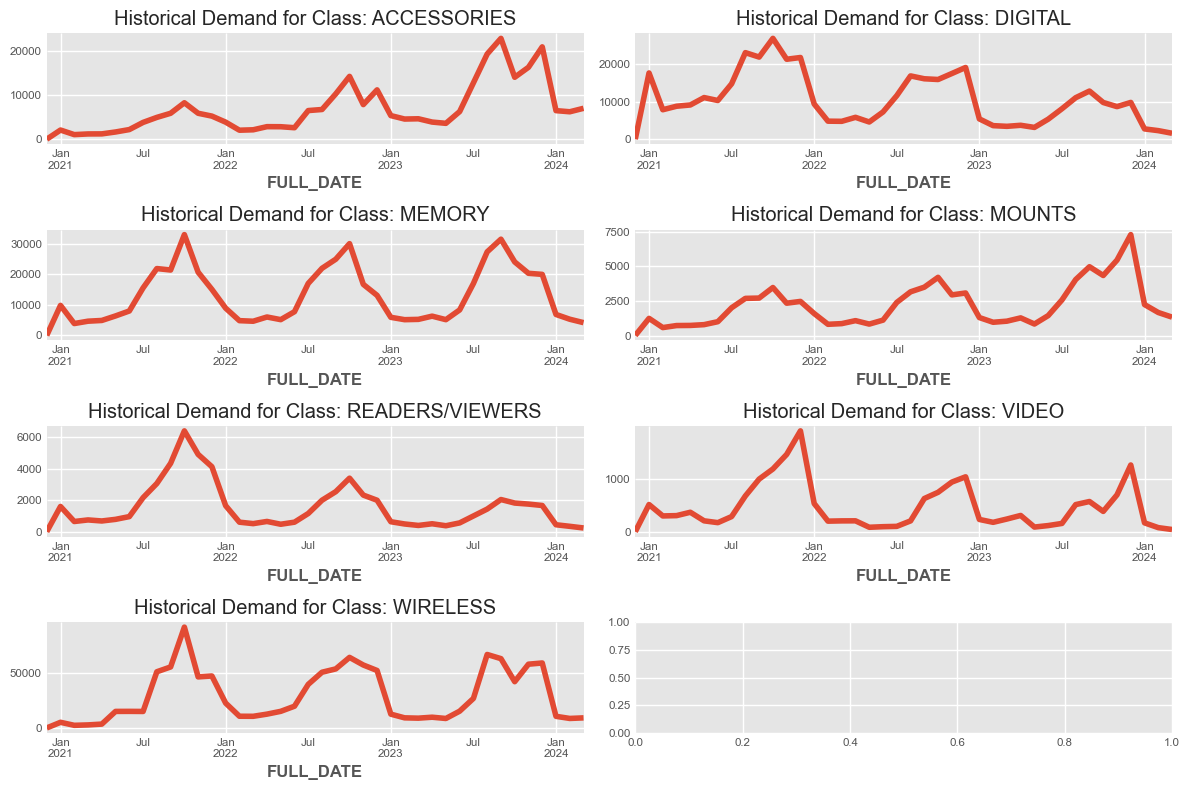

In [237]:
plt.style.use('ggplot') 

fig, ax = plt.subplots(ncols = 2, nrows = (len(class_piv.columns) + 1) // 2, figsize=(12,8))

ax = ax.flatten()

for i, class_ in enumerate(class_piv.columns): 

    class_piv[class_].plot(ax=ax[i])
    
    ax[i].set_title(f'Historical Demand for Class: {class_}')

plt.tight_layout()
plt.show()

In [238]:
import plotly.express as px 

yoy_class = class_piv.resample('a').sum().loc["2021":"2023"]


yoy_class
px.bar(yoy_class,title='Percentage of Unit Sales By Class-Year',barmode='group')

In [239]:
px.line(class_piv.loc["2023"],title='Category Wide Demand (Sub-Class Level) for 2023')

In [240]:
sku_sales = sales_df.groupby('SKU').resample('w')[['TOTAL_SALES']].sum().unstack()

In [244]:
skus_in_asst = [int(x) for x in skus_in_asst]

sku_piv = sku_sales.loc[skus_in_asst].T

In [247]:
asst_df.SKU = asst_df.SKU.astype(int)

sales_df_v = sales_df.merge(asst_df[['SKU','VENDOR_NAME']],on='SKU',how='left')

<Axes: title={'center': 'LY Vendor Performance (Demand)'}, ylabel='VENDOR_NAME'>

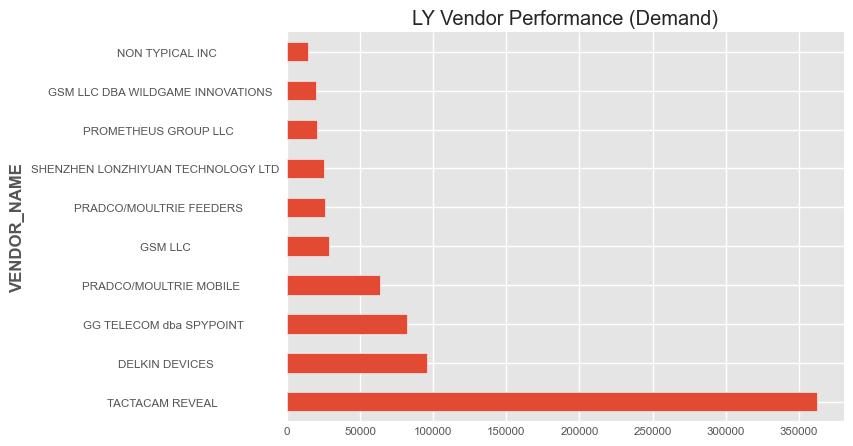

In [248]:
vend_piv = sales_df_v.query('YEAR == 2023').groupby(['VENDOR_NAME']).agg(doors = ('DOOR_COUNT','max'),
                                           avg_price = ('AVG_SALE_PRICE','mean'),
                                           total_sales = ('TOTAL_SALES','sum'),
                                           sku_ct = ('SKU','count')).round()


vend_piv['total_sales'].sort_values(ascending=False)[:10]\
    .plot(kind='barh',title='LY Vendor Performance (Demand)')

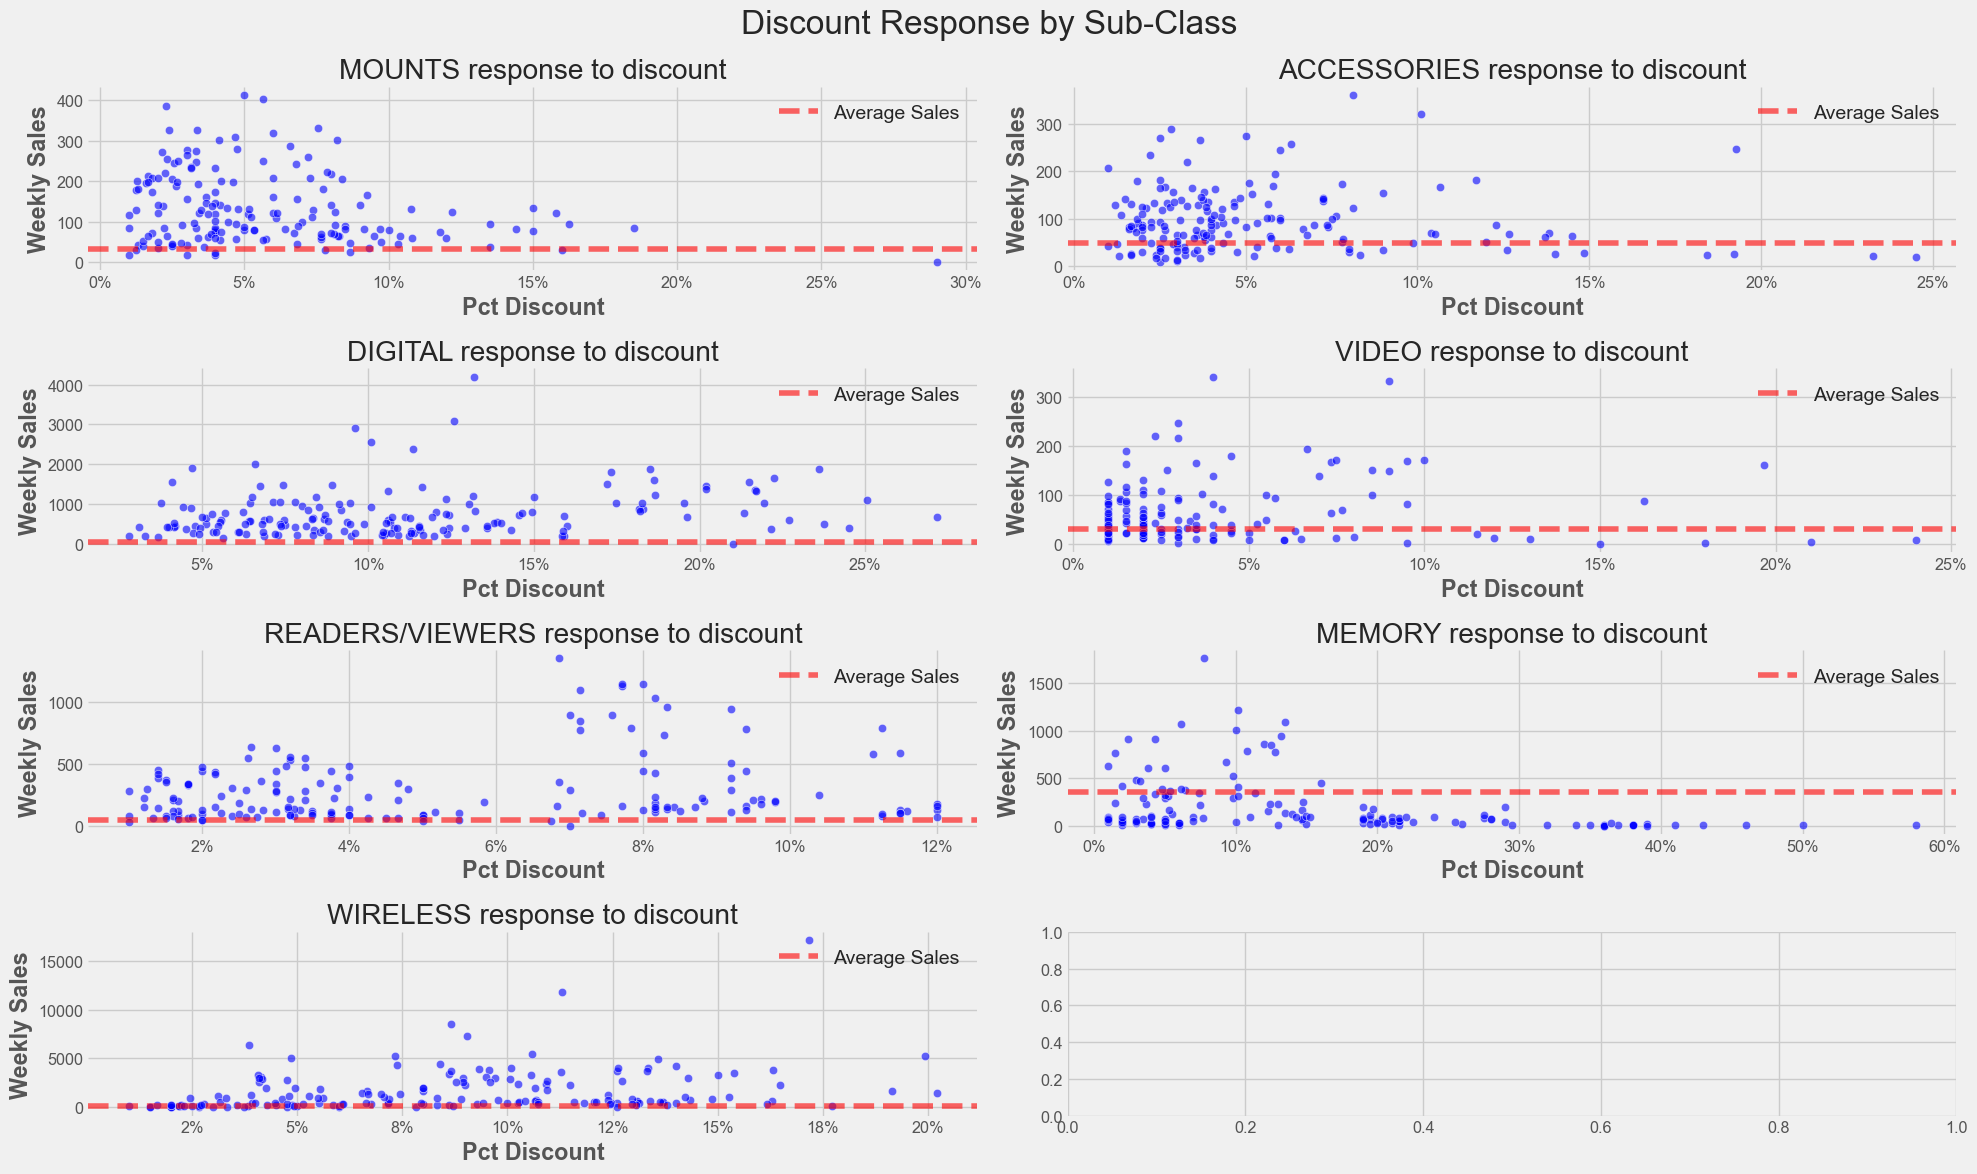

In [249]:

plt.style.use('fivethirtyeight')

classes = sales_df.SUBCLASS.unique().tolist()

fig, ax = plt.subplots(figsize=(20,12),ncols=2,nrows = (len(classes) + 1) // 2)

ax = ax.flatten() 

#format x axis as decimals 

from matplotlib.ticker import FuncFormatter

#define percentage formatter func 

def percent(x,pos):
    return  '{:.0%}'.format(x)

for i, group in enumerate(classes): 

#subset dataframe for class
    group_df = sales_df[sales_df.SUBCLASS == group] 

#get average of average weekly sales (could just do avg sales here)
    avg_sales = group_df.resample('w').TOTAL_SALES.mean().mean()

#pivot data where discount != 0 and resample to weekly datetime freq, avg discount and total sales by week
    piv = group_df.query('DISCOUNT_NEW  > 0').resample('w').agg(discount=('DISCOUNT_NEW','mean'),
                           sales=('TOTAL_SALES','sum'))

#plot data 
    sns.scatterplot(piv,x='discount',y='sales',ax=ax[i],alpha=.6,color='blue')

#set title, labels and horizontal axes line
    ax[i].set_title(f"{group} response to discount")

    ax[i].axhline(y=avg_sales,color='red',linestyle='--',label='Average Sales',alpha=.6)

    ax[i].legend()

    ax[i].set_xlabel('Pct Discount')
#format x axis into percentages
    ax[i].xaxis.set_major_formatter(FuncFormatter(percent))

    ax[i].set_ylabel('Weekly Sales')

fig.suptitle('Discount Response by Sub-Class',fontsize=24)
fig.tight_layout()

plt.show()

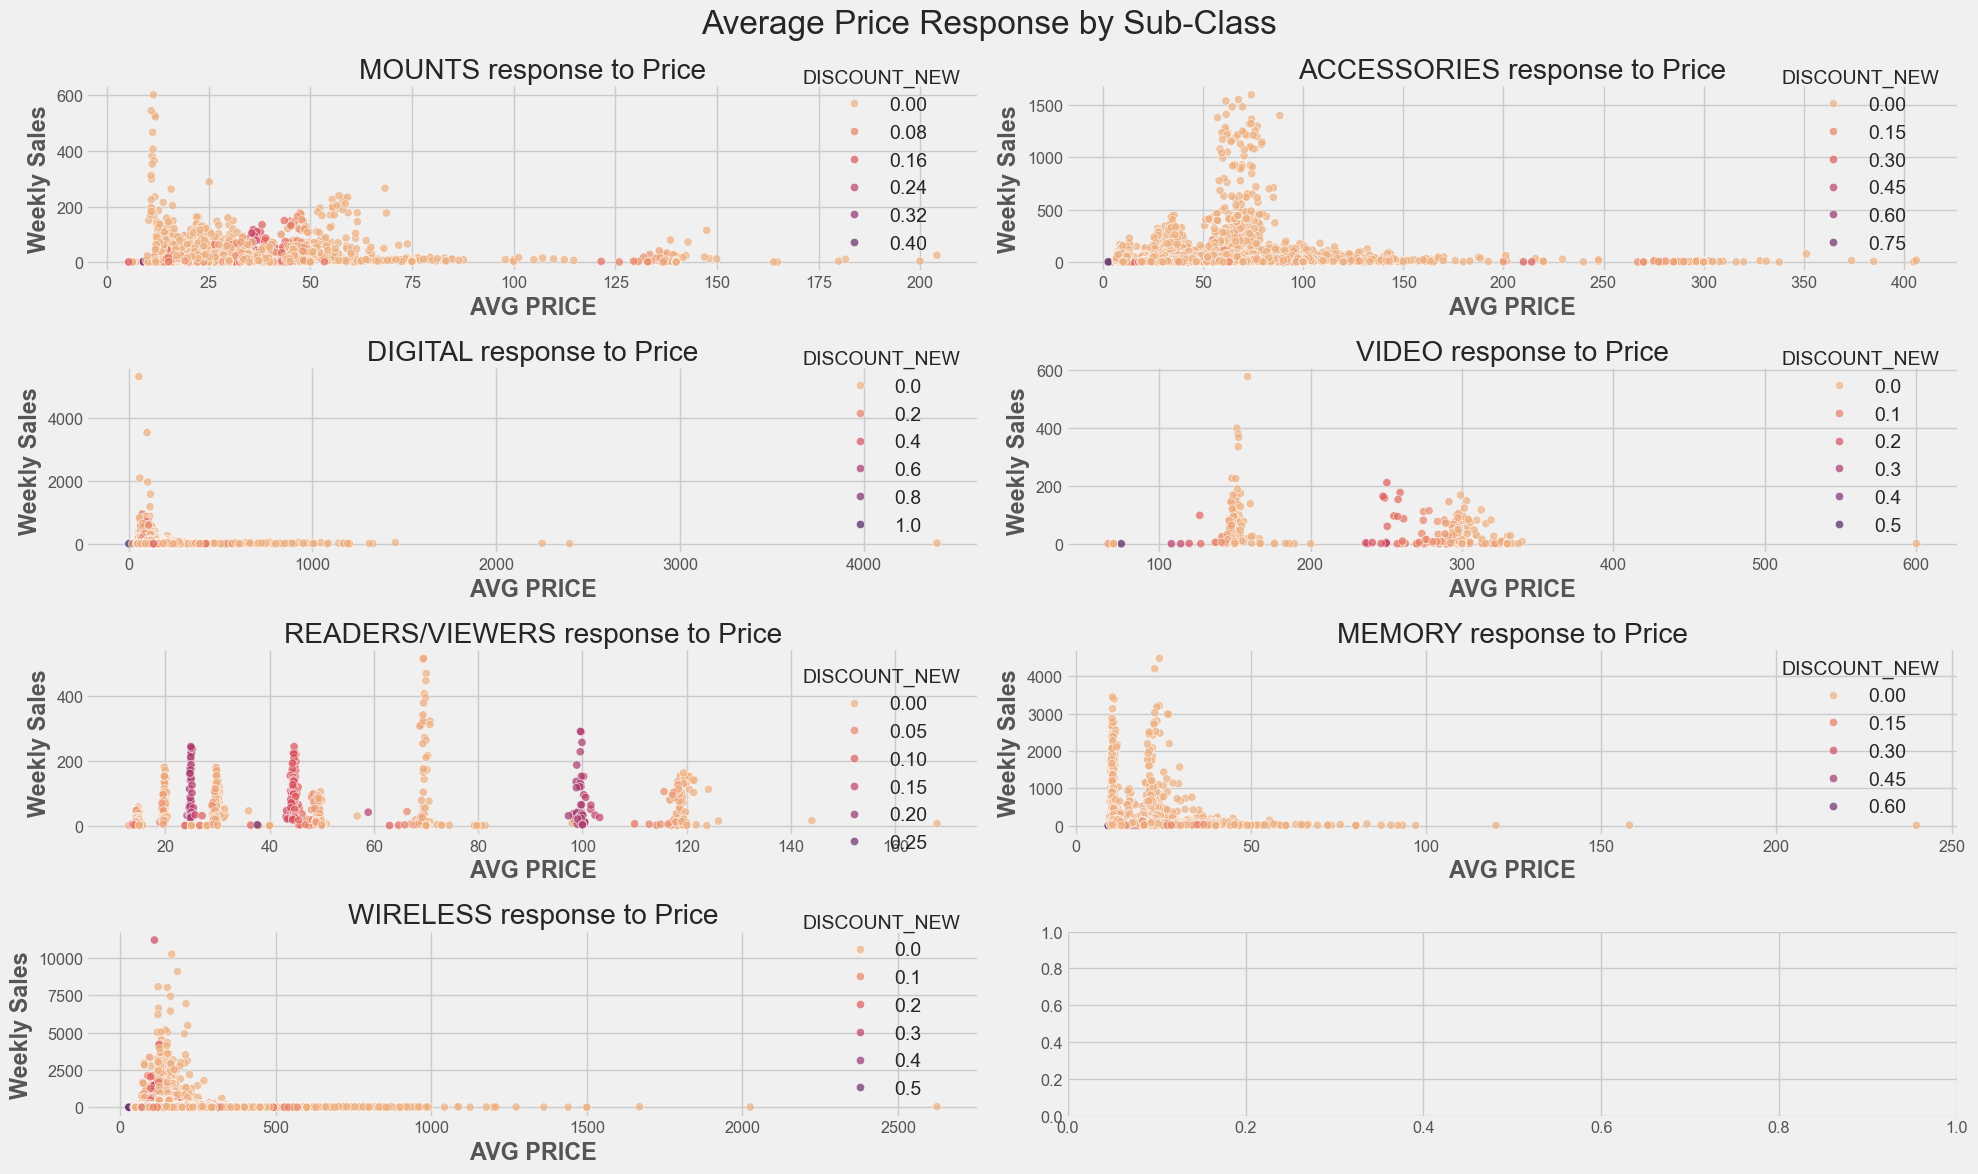

In [251]:

plt.style.use('fivethirtyeight')
classes = sales_df.SUBCLASS.unique().tolist()

fig, ax = plt.subplots(figsize=(20,12),ncols=2,nrows = (len(classes) + 1) // 2)

ax = ax.flatten() 

sns.set_style('dark')

for i, group in enumerate(classes): 

#subset dataframe for class
    group_df = sales_df[sales_df.SUBCLASS == group] 

#get average of average weekly sales (could just do avg sales here)
    avg_sales = group_df.resample('w').TOTAL_SALES.mean().mean()

#plot data 
    sns.scatterplot(group_df,x='AVG_SALE_PRICE',y='TOTAL_SALES',ax=ax[i],hue='DISCOUNT_NEW',palette='flare',alpha=.7)

#set title, labels and horizontal axes line
    ax[i].set_title(f"{group} response to Price")

    ax[i].set_xlabel('AVG PRICE')

    ax[i].set_ylabel('Weekly Sales')

fig.suptitle('Average Price Response by Sub-Class',fontsize=24)
fig.tight_layout()

plt.show()

In [252]:
sales_df = sales_df.assign(price_bins = sales_df.groupby('SUBCLASS')['AVG_SALE_PRICE'].transform(lambda x: pd.qcut(x,q=4)))

In [253]:
sales_by_week_price = sales_df.groupby(['SUBCLASS','price_bins','MONTH'])[['TOTAL_SALES']].mean()


plt.style.use('fivethirtyeight')

for subclass in sales_by_week_price.index.get_level_values(0).unique():

    fig = px.line(sales_by_week_price.loc[subclass].reset_index(),
            x='MONTH',
            y='TOTAL_SALES',
            color='price_bins',
            title=f'Price Elasticity of {subclass}')

    fig.show()
    #plt.xlabel('Price Quartiles')

   # plt.ylabel('Avg Sale Qty')

    #plt.show()

In [254]:
a = sales_df.query('YEAR in(2022,2023)').groupby(['SUBCLASS','price_bins','YEAR'])[['TOTAL_SALES']].sum()

b = a.groupby(['YEAR','SUBCLASS']).idxmax()[['TOTAL_SALES']]#.merge(a.reset_index(1),how='inner')

b = b.reset_index(drop=True).set_index('TOTAL_SALES')

indx = b.index.tolist()

top_sales = pd.DataFrame(indx,columns=['SUBCLASS','BIN','YEAR'])

top_sales=top_sales.merge(a,left_on=['SUBCLASS','BIN','YEAR'],right_index=True)

In [255]:
top_sales_by_bin_yr = top_sales.groupby(['SUBCLASS','BIN','YEAR']).sum().unstack().fillna('NONE')

top_sales_by_bin_yr

TOTAL_SALES          
YEAR                                                 2022      2023
SUBCLASS        BIN                                                
ACCESSORIES     (45.59, 69.99]                       NONE   61754.0
                (69.99, 406.24]                   33379.0      NONE
DIGITAL         (0.009000000000000001, 94.99]     59343.0      NONE
                (94.99, 127.795]                     NONE   37714.0
MEMORY          (9.299000000000001, 14.238]       98116.0      NONE
                (20.92, 31.735]                      NONE   78577.0
MOUNTS          (5.348999999999999, 18.385]        8261.0   12448.0
READERS/VIEWERS (19.91, 29.83]                       NONE    3972.0
                (29.83, 49.99]                     5808.0      NONE
VIDEO           (66.389, 149.99]                   2173.0    1943.0
WIRELESS        (120.46, 159.43]                 198821.0  175463.0

# getting sku level KAD for go forward

In [269]:
sku_cad = pd.read_csv(r"C:\Users\jrodenberg\Documents\sku_cad.csv",header=None).dropna()

sku_cad.columns = ['SKU','KAD']

sku_cad = sku_cad.where(~(sku_cad.SKU == 'new')).dropna()

sku_cad.SKU = sku_cad.SKU.astype(int)

kad_sales = sales_df.merge(sku_cad,left_on=['SKU'],right_on=['SKU'])

#kad_sales.groupby(['SUBCLASS']).agg()

In [270]:
#filter for this yeay to get LY drop and keep total sales 

kad_sales_ty = kad_sales.query('YEAR == 2023')

kad_agg_sales = kad_sales_ty.groupby('KAD')['TOTAL_SALES'].sum()

#get keep and drop sales 
keep_sales = kad_agg_sales.loc['KEEP']

drop_sales = kad_agg_sales.loc['DROP']

#examine keep vs drop sales, sku counts and existing inventory, then look at how we will dispose of inventory as total inventory / avg weekly sales to get number of weeks needed to dispose. 

In [271]:
drop_weekly = kad_sales_ty.groupby(['KAD','SKU'])['TOTAL_SALES'].mean().round().loc["DROP"]

sku_list = kad_sales[kad_sales.KAD == 'DROP']['SKU'].unique()

FEED UNIQUE DROP SKUS TO ASST QUERY 

In [272]:

#import data from domo 
drop_sku_oh = pd.read_csv(r"C:\Users\jrodenberg\Downloads\ALL SKU CUR INFO (7).csv").infer_objects()[['SKU','DESC','TOT OH','TOT OH $','R12 UNITS']]
#convert list to ints 
sku_list = [int(x) for x in sku_list]
#filter for drops 
drop_oh = drop_sku_oh[drop_sku_oh.SKU.isin(sku_list)]
#merge avg weekly sales for drop skus 

drop_weekly.index = drop_weekly.index.astype(int)

drop_oh = drop_oh\
    .merge(drop_weekly,on='SKU')\
        .rename(columns={'TOTAL_SALES':'AVG_WEEKLY_SALES'})

drop_oh = drop_oh\
    .assign(weeks_to_sell = drop_oh['TOT OH'].div(drop_oh['AVG_WEEKLY_SALES']).round(),
            years_of_sales_oh = drop_oh['TOT OH'].div(drop_oh['R12 UNITS']).round(2))\
        .sort_values(by='TOT OH',ascending=False)

# Memory: selling best under 30$ 

# Wireless selling best under 200 

# Accessories selling best in 50-100 range 

# digital and mounts, the cheaper the better 

define skus to fcst list 

In [273]:
sku_to_fcst = [1616549,
1692310,
1692311,
1692687,
2881671,
2030826,
2030830,
2165406,
2297788,
2112119,
2301804,
2705876,
2517623,
2954500,
2977350,
3253630,
2517625,
2301808,
2423799,
2416498,
2416499,
2517628,
2836345,
2836344,
2416515,
2836340,
2518744,
2611901,
2692766,
2692768,
2878135,
3427121,
3658079,
3688108,
3953813,
3088361,
3049395,
3953816,
3088360,
3049396,
2692862,
2646065,
3506252,
2692866,
3085006,
5020286,
3953815,
3953814,
3451284,
3451285,
2883537,
3688109,
2692868,
2697297,
2883473,
2705331,
2883472,
2878081,
2878082,
2704287,
3065215,
3065214,
3943156,
3943158,
3408506,
2737415,
2740474,
2741467,
2744505,
2750200,
3408492,
2878088,
3690273,
2811437,
3433688,
2821873,
3065881,
2692637,
3943160,
3690118,
3690114,
3433695,
3065922,
3433707,
3690271,
2810298,
2810299,
2880735,
3079254,
2414874,
3418807,
3943161,
3943159,
3689571,
3433687,
3063791,
2883335,
2883333,
4511913,
2878089,
3688123,
3943167,
3943168,
2880984,
2878132,
3931913,
2878133,
3407711,
3079281,
2880981,
3932831,
3079458,
2880982,
3079258,
3079259,
3690116,
3028419,
4932665,
2298665,
2519299,
3079261,
3408360,
3688139,
2568715,
3059317,
2519060,
5063132,
2883515,
2883517,
2861215,
3903675,
3063766,
4774923,
3059318,
3059339,
3059340,
3417444,
2679385,
3943172,
2216346,
2883466,
2216342,
2707937,
3932916,
3689564,
3058972,
3688132,
3932917,
3688133,
3931897,
3688143,
3688144,
3726813,
2705867,
2519395,
2705856,
2705857,
3079303,
3955215,
3079304,
3688125,
3932873,
2913941,
3931912,
3418490,
3417711,
3417720,
3281601,
3932840,
3418804,
3369789,
3369790,
3369793,
3931898,
3400449,
3932872,
3955214,
3635283,
3967304,
3932839,
2302997,
3418430,
3932838,
3919151,
2518785,
3063743,
3690121,
2679378,
4572844,
2412683,
3079284,
3079285,
3000637,
3281598,
4899653,
3281597,
3000636,
3932870,
3688812,
3417695,
2881027,
2977392,
2992430,
3079294,
2977209,
2881026,
3418335,
3079264,
3049970,
3953817,
2883726,
2883727,
3688810,
2883467,
3844966,
3931899,
3690267,
3065212,
2883469,
3967307,
3418439,
3932871,
3079256,
3079257,
2410432,
5063242,
3688120,
5063247,
3550985,
2883706,
3433693,
3065882,
3433661,
3919150,
2581801,
3731787,
3689567,
3689566,
3574476,
3959599,
3574477,
3408317,
3689806,
2518787,
2679374,
3932918,
3943170,
3932874,
2679383,
3932875,
3689274,
3808378,
4304630,
4899656,
3818268,
2679381,
2414153,
3932836,
4579572,
3267150,
3451740,
2012804,
2298535,
3690264,
3690270,
3808380,
4164316,
2679372,
3688116,
2679373,
3690190,
3408373,
2568701,
2883815,
3808382,
3744004,
2568702,
2302984,
2883738,
4291756,
3690274,
2518749,
2474015,
3971122,
3932837,
3433669,
3210477,
2692418,
3242604,
4076363,
3408353,
2977210,
2692664,
2568590,
2540712,
2811441,
3242617,
2423795,
2880768,
2517821,
3506253,
3433703,
3028468,
3932876,
3065879,
2929532,
3085004,
3433692,
2692646,
3690265,
3418422,
2883361,
2883360,
2423791,
2880858,
3408326,
2303216,
3513114,
3513114,
3028470,
2692422,
2880736,
3028464,
3932835,
2692420,
3408328,
3971121,
2423802,
3690167,
3028472,
3932843,
3932877,
3517366,
3932878,
2883315,
3689569,
3932841,
2883314,
4454441,
3517055,
3943173,
2810296,
4153906,
2008058,
4418354,
4454451,
3932842,
4488305,
3943166,
3931900,
2679379,
4572855,
3433658,
4650310,
3063742,
4837890,
2705223,
3433651,
3079459,
4942462,
4942464,
2008992,
4530452,
4077317,
]

In [274]:
sales_ts = sales_df[sales_df.SKU.isin(sku_to_fcst)].resample('w')['TOTAL_SALES'].sum()

In [ ]:
#forecast_holt_winters optimized ETS function (forecasts at weekly frequency for 1 year ahead or n_periods)
 
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
import optuna
import warnings
 
def forecast_holts_winters_opt(ts_data,
 seasonal_periods=52,
 trend = 'add',
 seasonal = 'add',
 damped_trend=False,
 show_plot=False,
 n_iter=500):
   
    warnings.filterwarnings('ignore')
        #specify n_splits as 5-fold cv
    n_splits = 2
    #specify minimum training size of 2 seasonal cycles obs
    #min_train_size = seasonal_periods * 2
 
    tscv = TimeSeriesSplit(n_splits=n_splits)
 
    for train_index, test_index in tscv.split(ts_data):
 
      train_data, test_data = ts_data.iloc[train_index], ts_data.iloc[test_index]
 
      #define optima alpha (level), beta (trend), gamma (seasonal)
    def objective(trial):
        # Define the parameter space to be searched
        alpha = trial.suggest_float('alpha', 0, .5, step=0.025)
        beta = trial.suggest_float('beta', 0, .5, step=0.025)
        gamma = trial.suggest_float('gamma', 0, .3, step=0.025)
 
            # Fit Holt-Winters Exponential Smoothing model
        model = ExponentialSmoothing(train_data,
            trend=trend, seasonal=seasonal,
            seasonal_periods=seasonal_periods,
            initialization_method="estimated",
            damped_trend=damped_trend)
           
        fit_model = model.fit(smoothing_level=alpha,
                                  smoothing_trend=beta,
                                  smoothing_seasonal=gamma)
 
            # Make predictions
        predictions = fit_model.predict(start=0,
                                            end=len(train_data)-1)
 
            # Calculate MAE and store it
        mae = mean_absolute_error(train_data, predictions)

        rmse = mean_squared_error(train_data,predictions,squared=False)
 
          # Return the average MAE across folds
        return mae
 
      # Create an Optuna study object and optimize the objective function
    optuna.logging.set_verbosity(optuna.logging.WARNING)
 
    study = optuna.create_study(direction='minimize')
 
    study.optimize(objective, n_trials=n_iter)
 
      # Get the best hyperparameters, and best Mean Abs Error
    best_params = study.best_params
 
    best_mae = study.best_value
 
      # Print the best hyperparameters
    print("Best Hyperparameters:", best_params)
 
      # Fit the model with the best hyperparameters on the entire dataset
    best_model = ExponentialSmoothing(ts_data,
                                        trend=trend,
                                          seasonal=seasonal,
                                            seasonal_periods=seasonal_periods,
                                            initialization_method="estimated")
 
    best_fit_model = best_model.fit(smoothing_level=best_params['alpha'],
                                      smoothing_slope=best_params['beta'],
                                      smoothing_seasonal=best_params['gamma'])
 
      # Make predictions with the best model
    best_predictions = best_fit_model.predict(start=len(train_data), end=len(train_data) + len(test_data) -1)
 
    model_bias = np.mean(best_predictions - test_data)
 
    model_rmse = mean_squared_error(best_predictions,test_data,squared=False)
 
    print(f'MODEL MAE: {round(best_mae, 2)}')
 
    print(f'MODEL MAE %: {round(best_mae / test_data.mean(), 2)}')
       
    print(f'MODEL Bias: {round(model_bias, 2)}')
 
    print(f'MODEL Bias %: {round(model_bias / test_data.mean(), 2)}')
 
    print(f'MODEL RMSE: {round(model_rmse)}')
      #if true then plots future forecast and predictions against test
    if show_plot == True:
            plt.style.use('seaborn-v0_8-bright')

            fig, ax = plt.subplots(figsize=(20,10))

            sns.lineplot(x=train_data.index,y=train_data, label='Train Data',ax=ax,linewidth=2)
 
            sns.lineplot(x=test_data.index,y=test_data, label='Test Data',ax=ax,linewidth=2)
 
            sns.lineplot(x=best_predictions.index,y=best_predictions, label='Predicted',ax=ax,linewidth = 2)

            plt.legend()
 
            plt.show()
  #returns best model summary object
    return best_fit_model

In [276]:
import pandas as pd

#develops forecast dataframe based on the series, item_proportional sales by week and set params
def forecast_df_exp(preds,df,class_):

   # Reconciling the forecast by SKU-Week

   #developing sku_profiles (selling pattern and breaking out forecast by these ratios as well)

   sku_weekly = df.query('YEAR == 2023 & SUBCLASS in @class_').groupby(['SKU','WEEK'])[['TOTAL_SALES']].sum() 

   sku_tot = df.query('YEAR == 2023 & SUBCLASS in @class_').groupby('SKU')[['TOTAL_SALES']].sum()

   weekly_demand = df.query('YEAR == 2023 & SUBCLASS in @class_').groupby(['WEEK'])[['TOTAL_SALES']].sum()

   sku_week = sku_weekly.join(sku_tot,lsuffix='_sku')

   sku_ratios = pd.DataFrame(sku_week['TOTAL_SALES_sku']/sku_week['TOTAL_SALES']).reset_index().rename(columns={0:'sku_alloc_ratio'})

   #transforming future forecast series into a dataframe with week index  --MODEL OUTPUT-- 

   week = preds.index.isocalendar().week

   fut_df = pd.concat([preds,week],axis=1).set_index('week').rename(columns={0:'fcst'})

   #allocation of forecast based on last years weekly sales ratios join future forecast data, last year's demand data and rename columsns 
   sku_alloc = sku_ratios.set_index('WEEK')\
   .join(fut_df)\
   .join(weekly_demand)\
   .rename(columns={'TOTAL_SALES':'ly_weekly_demand'})

   #develop sku_forecasts 
   sku_alloc['sku_fcst'] = sku_alloc['sku_alloc_ratio'] * sku_alloc['fcst']

   #sku forecast pivot
   sku_piv = sku_alloc.reset_index()\
   .pivot(index='WEEK',columns='SKU',values='sku_fcst')\
   .round().fillna(0)



   #join in last year's demand to compare to model output as ly pred comp
   sku_ratios.set_index('WEEK')\
   .join(fut_df)\
   .join(weekly_demand)\
   .rename(columns={'TOTAL_SALES':'ly_weekly_demand'})

   #join in last year's demand to compare to model output as ly pred comp
   ly_pred_comp = sku_alloc[['ly_weekly_demand','fcst']]


   return sku_piv, ly_pred_comp

Pull residuals from models.

In [ ]:
#create past covariates 
def create_covs(df, holt_winters,weekly_target):

    from statsmodels.tsa.seasonal import seasonal_decompose
    from darts import TimeSeries
    from darts.utils.statistics import check_seasonality,extract_trend_and_seasonality, plot_acf, plot_pacf, stationarity_test_adf
    
    #preprocess DF 
    df[['DISCOUNT_NEW','EVT_PRICE']] = df[['DISCOUNT_NEW','EVT_PRICE']].astype(float)

    df['EVT_START'] = pd.to_datetime(df['EVT_START'],yearfirst=True)

    df['EVT_END'] = pd.to_datetime(df['EVT_END'],yearfirst=True)

    #aggregate series and prepare covariates 
    covs = df.resample('w').agg(avg_vel = ('VELOCITY','mean'),
                              avg_str_ct = ('DOOR_COUNT','mean'),
                                avg_price = ('AVG_SALE_PRICE','mean'),
                                is_evt = ('EVENT_SALE_FLAG','max'),
                                items_in_evt = ('EVENT_SALE_FLAG','sum')).round(4)
    

    #---------------------------------READ IN FUTURE DATES AND TRANSFORM DF----------------------------------------------------------------------------------
    #read in future events 

    evts = pd.read_csv(r"C:\Users\jrodenberg\Downloads\TAB SCHEDULE (1).csv")

    cpi = pd.read_excel(r"C:\Users\jrodenberg\OneDrive - Bass Pro Shops\Desktop\CPI.xlsx").infer_objects()

    cpi.columns = cpi.columns.str.lower()

    event_dates = evts[['Sale Start','Sale End']].infer_objects()

    event_dates.index = pd.date_range(start=weekly_target.index.max(),periods=61,freq='w')

    event_dates['Sale Start'] = pd.to_datetime(event_dates['Sale Start'])

    event_dates['Sale End'] = pd.to_datetime(event_dates['Sale End'])


    dates = event_dates\
    .assign(fut_event = np.where((event_dates.index > event_dates['Sale Start'].min()) & (event_dates.index < event_dates['Sale End'].max()),1,0))

    #create future covs 

    fut_covs = pd.concat([covs['is_evt'],dates['fut_event']])

    fut_covs = fut_covs.resample('w').max()

    fut_covs = TimeSeries.from_series(fut_covs)

    #extract residuals as ML feature
    exp_residuals = holt_winters.resid

    weekly_target = TimeSeries.from_series(weekly_target)

    
    trend, seasonal = extract_trend_and_seasonality(weekly_target)

    #merge in new features on index 

    exp_residuals.name='ets_resid'

    #'WEEK','YEAR','MONTH'
    covs = covs\
        .merge(seasonal.pd_series(),how='left',left_index=True,right_index=True)\
        .merge(exp_residuals,how='left',left_index=True,right_index=True)\
        .merge(cpi,how='left',left_on=[covs.index.year,covs.index.month],right_on=['year','month'])\
            .set_index(covs.index)\
            .fillna(method='ffill')
    
    covs = covs.rename(columns = {'0':'seasonal_comp_ets'})

    #convert covs to TimeSeries object 
    past_covs = TimeSeries.from_dataframe(covs)

    return past_covs, fut_covs,weekly_target 

Best Hyperparameters: {'alpha': 0.25, 'beta': 0.0, 'gamma': 0.025}
MODEL MAE: 1132.92
MODEL MAE %: 0.07
MODEL Bias: 126.88
MODEL Bias %: 0.01
MODEL RMSE: 2212


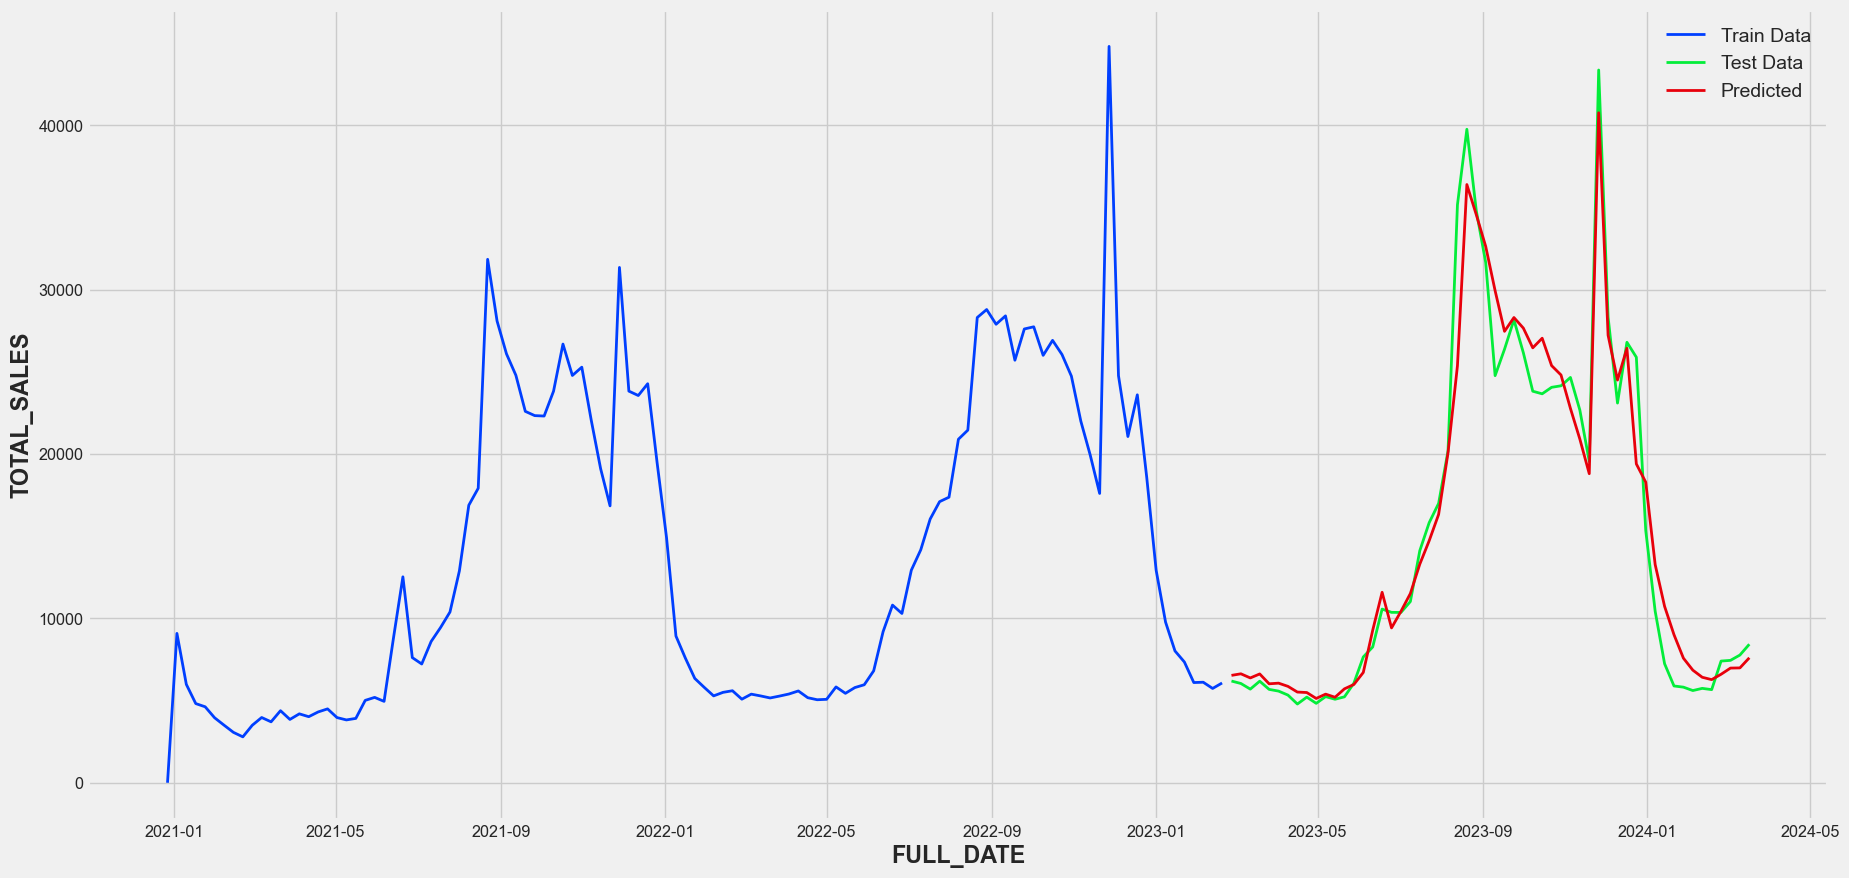

In [277]:
exp_mod =  forecast_holts_winters_opt(sales_ts,n_iter=500,damped_trend=True,show_plot=True)


past_covs, fut_covs,target  = create_covs(sales_df,exp_mod,sales_ts)

#create empty dict to store past, future covs and target 

darts_dict = {}


for col in sales_df.SUBCLASS.unique(): 

    #class level item attributes subset
    class_data = sales_df[sales_df.SUBCLASS == col]

    #pull exp smooth residuals for class 
    exp_smooth = models[col]

    #class sales weekly series 
    class_sales = sales_ts[col]

    #create past and future covariates
    past_covs, fut_covs, target = create_covs(class_data,exp_smooth,class_sales)

    darts_dict[col] = [past_covs,fut_covs,target]

Add Encoders and scale the data

In [279]:

#add encoders and incorporate scaler (trying this to see if scaler improves score) 

from darts.dataprocessing.transformers import Scaler

def encode_year(idx):
    return (idx.year - 1950) / 50

add_encoders={
    'cyclic': {'past': ['week','month']},
    'cyclic':{'future':['week','month']},
    'datetime_attribute': {'future': ['week','day','month','quarter','year']},
    'datetime_attribute': {'past': ['week','day','month','quarter','year']},
    'position': {'past': ['relative'], 'future': ['relative']},
    'custom': {'past': [encode_year]},
    'tz': 'CET',
    'transformer':Scaler()
}

In [ ]:
from darts.models import RegressionModel 

from darts.metrics import rmse, mae

    #----------------FORECAST WITH LIGHTGBM-----------------------------------------------------------------------------

import matplotlib.pyplot as plt
import optuna
from darts.models import LightGBMModel
from darts.metrics import rmse, mae


def forecast_lightgbm(target_train,
                      target_test, 
                      covs_train, 
                      covs_test, 
                      add_encoders=add_encoders,
                      lags=[-1, -2, -3, -4,-5,-6,-7,-8,-9,-10],
                        past_lags=[-1, -2, -3, -4,-5,-6,-7,-8,-9,-10],
                        fut_covs = fut_covs,
                        fut_lags=[1,2,3,4,5,6],
                          show_plot=False):
    # Same code as forecast_random_forest, but with LightGBM model
    model = LightGBMModel(
    lags=lags,
    lags_past_covariates=past_lags,
    lags_future_covariates=fut_lags,
    output_chunk_length=52,
    use_static_covariates=True,
    add_encoders=add_encoders,
    verbose=-1
    )

    model.fit(target_train, past_covariates=covs_train,future_covariates=fut_covs)

    pred = model.predict(n=52,
    series=target_train,
    past_covariates=covs_train)
    #run optuna to minimize RMSE 

    def objective(trial):
        # Define the hyperparameters to optimize
        num_leaves = trial.suggest_int('num_leaves', 20, 250)
        learning_rate = trial.suggest_loguniform('learning_rate', 0.01, 0.5)
        min_child_samples = trial.suggest_int('min_child_samples', 5, 100)
        subsample = trial.suggest_uniform('subsample', 0.5, 1.0)
        colsample_bytree = trial.suggest_uniform('colsample_bytree', 0.5, 1.0)
        n_estimators = trial.suggest_int('n_estimators', 50, 300)
        # Create and train the model with the hyperparameters
        model = LightGBMModel(
           lags=lags,
        lags_past_covariates=past_lags,
        lags_future_covariates=fut_lags,
            output_chunk_length=52,
            use_static_covariates=True,
            add_encoders=add_encoders,
           num_leaves = num_leaves,
        learning_rate = learning_rate,
        min_child_samples = min_child_samples,
        subsample = subsample,
        colsample_bytree = colsample_bytree,
        n_estimators = n_estimators,
        verbose=-1,
        linear_tree=True
        )
        model.fit(target_train, past_covariates=covs_train,future_covariates=fut_covs)
        # Make predictions with the trained model
        pred = model.predict(n=52, series=target_train, past_covariates=covs_train,future_covariates=fut_covs)
        # Calculate the evaluation metric (Mean Absolute Percentage Error)
        score = rmse(pred, target_test)

        return score
    # Create a study object and optimize the objective function
    study = optuna.create_study(direction='minimize')
    study.optimize(objective, n_trials=100)
    # Get the best parameters
    best_params = study.best_params
    print("Best parameters:", best_params)

    #fit new model with best params 
    model = LightGBMModel(
        lags=lags,
        lags_past_covariates=past_lags,
        lags_future_covariates=fut_lags,
        output_chunk_length=52,
        use_static_covariates=True,
        add_encoders=add_encoders,
        **best_params,
        verbose=-1,
        linear_tree=True)
        
    model.fit(target_train, past_covariates=covs_train,future_covariates=fut_covs)
    # Make predictions with the trained model
    pred = model.predict(n=len(target_test), series=target_train, past_covariates=covs_train)

 # Calculate RMSE and MAE scores
    rmse_score = round(rmse(pred, target_test) / (target_test.pd_series().max() - target_test.pd_series().min()),3)
    mae_score = round(mae(pred, target_test) / (target_test.pd_series().max() - target_test.pd_series().min()),3)  
    print(f"RMSE: {rmse_score}")
    print(f"MAE: {mae_score}")
    if show_plot == True: 
        plt.style.use('fivethirtyeight')
            # Plot predictions against the test set data
        plt.figure(figsize=(10, 6))
        plt.plot(target_test.pd_series(), label='True')
        plt.plot(pred.pd_series(), label='Predicted')
        plt.title('LightGBM Predictions vs True Values',fontsize=16)
        plt.xlabel('Time')
        plt.ylabel('Demand')
        plt.legend()
        # Add RMSE and MAE scores as text annotations
        plt.text(plt.xlim()[0], plt.ylim()[1] * 0.3, f'Relative RMSE: {rmse_score * 100}%', ha='left', va='bottom')
        plt.text(plt.xlim()[0], plt.ylim()[1] * 0.25, f'Relative MAE: {mae_score * 100}%', ha='left', va='bottom')
        plt.show()
       


    final_model = LightGBMModel(
        lags=lags,
        lags_past_covariates=past_lags,
        lags_future_covariates=fut_lags,
        output_chunk_length=52,
        use_static_covariates=True,
        add_encoders=add_encoders,
        **best_params,
        verbose=-1,
        likelihood='poisson',
        linear_tree=True)

    final_model.fit(target,past_covariates=past_covs,future_covariates=fut_covs)

    final_preds = final_model.predict(n=52,
                                       series=target,
                                      future_covariates=fut_covs,
                                       past_covariates=past_covs,num_samples=150)

    return final_model, final_preds

Best parameters: {'num_leaves': 199, 'learning_rate': 0.16479027408738775, 'min_child_samples': 13, 'subsample': 0.9509910885679755, 'colsample_bytree': 0.6890894080129087, 'n_estimators': 230}
RMSE: 0.088
MAE: 0.068


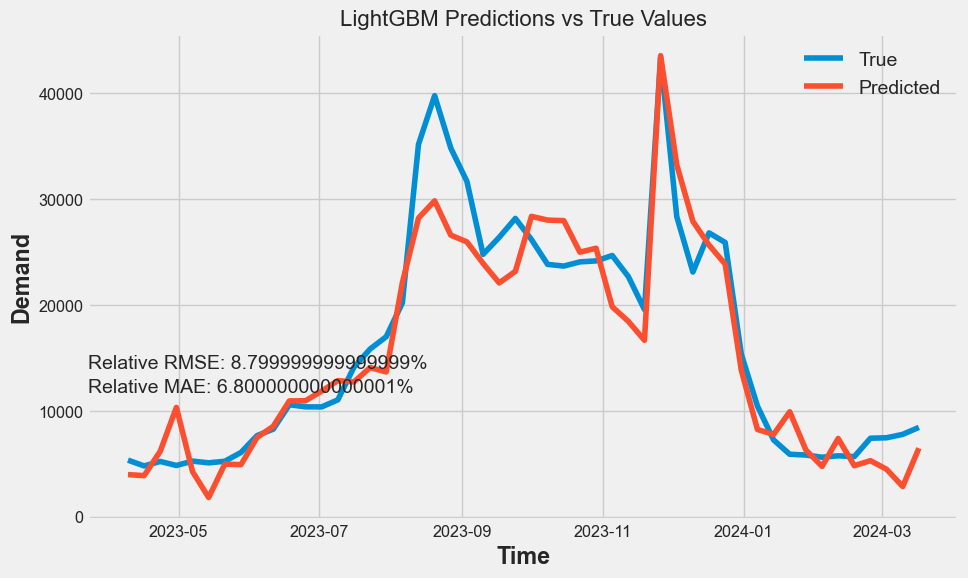

In [280]:
#split data and forecast 


#split the data differently, train model on 2 full years of seasonal cycle then predict on last years seasonal cycle! 
from darts.utils.model_selection import train_test_split

covs_train, covs_test = train_test_split(past_covs,test_size=.3)

target_train, target_test = train_test_split(target,test_size=.3)

#lightgbm forecasting 

model, preds = forecast_lightgbm(target_train,
                  target_test,
                  covs_train,
                  covs_test,
                  add_encoders=add_encoders,
                  fut_covs=fut_covs,
                  show_plot=True)   

In [397]:
#preds = preds.pd_dataframe().median(axis=1)

# Reconciling the forecast by SKU-Week

#developing sku_profiles (selling pattern and breaking out forecast by these ratios as well)

sku_weekly = sales_df.query('YEAR == 2023').groupby(['SKU','WEEK'])[['TOTAL_SALES']].sum() 

sku_tot = sales_df.query('YEAR == 2023').groupby('SKU')[['TOTAL_SALES']].sum()

weekly_demand = sales_df.query('YEAR == 2023').groupby(['WEEK'])[['TOTAL_SALES']].sum()

sku_week = sku_weekly.join(sku_tot,lsuffix='_sku')

sku_ratios = pd.DataFrame(sku_week['TOTAL_SALES_sku']/sku_week['TOTAL_SALES']).reset_index().rename(columns={0:'sku_alloc_ratio'})

#transforming future forecast series into a dataframe with week index  --MODEL OUTPUT-- 

week = preds.index.isocalendar().week

fut_df = pd.concat([preds,week],axis=1).set_index('week').rename(columns={0:'fcst'})

#allocation of forecast based on last years weekly sales ratios join future forecast data, last year's demand data and rename columsns 
sku_alloc = sku_ratios.set_index('WEEK')\
.join(fut_df)\
.join(weekly_demand)\
.rename(columns={'TOTAL_SALES':'ly_weekly_demand'})

#develop sku_forecasts 
sku_alloc['sku_fcst'] = sku_alloc['sku_alloc_ratio'] * sku_alloc['fcst']

sku_alloc = sku_alloc.sort_index() 

sku_alloc = sku_alloc.assign(ly_weekly_sales = round(sku_alloc['sku_alloc_ratio'] * sku_alloc['ly_weekly_demand']))

#sku forecast pivot
sku_piv = sku_alloc.reset_index()\
.pivot(index='WEEK',columns='SKU',values='sku_fcst')\
.round().fillna(0)



#join in last year's demand to compare to model output as ly pred comp
sku_ratios.set_index('WEEK')\
.join(fut_df)\
.join(weekly_demand)\
.rename(columns={'TOTAL_SALES':'ly_weekly_demand'})

#join in last year's demand to compare to model output as ly pred comp
ly_pred_comp = sku_alloc.sort_index()

ly_pred_comp = ly_pred_comp.reset_index().groupby('WEEK').median()

In [558]:
#sku level forecast reconciliation function 

def sku_level_dist(df,preds): 

    #sku level annual sales from ly 
    sku_tot = df.query('YEAR == 2023').groupby('SKU')[['TOTAL_SALES']].sum()

    #sku_level total sales as proportion of total sales in ly 
    sku_ratio = sku_tot['TOTAL_SALES'] / df.query('YEAR == 2023').TOTAL_SALES.sum()

    #multiply sku annual ratio by top line fcst 
    sku_fcst = sku_tot.assign(item_annual_fcst = sku_ratio * preds.sum())

    #create fcst df and merge sku level annual fcst 
    df_fcst = sku_ratios.set_index('WEEK').sort_index().merge(sku_fcst,left_on='SKU',right_index=True).drop('TOTAL_SALES',axis=1)

    #multiply ratio of sku by annual item fcst to get weekly level fcst 
    df_fcst = df_fcst.assign(sku_fcst = df_fcst['sku_alloc_ratio'] * df_fcst['item_annual_fcst'])

    #item level annual fcst 
    item_fcst = df_fcst.reset_index().groupby('SKU')['item_annual_fcst'].mean().round()

    #item-week level fcst 
    sku_level_fcst = df_fcst.groupby(['SKU','WEEK'])['sku_fcst'].mean().round().sort_index()

    return item_fcst, sku_level_fcst

In [560]:
item_annual, sku_level = sku_level_dist(sales_df,preds)

In [393]:
import pandas as pd

#develops forecast dataframe based on the series, item_proportional sales by week and set params
def forecast_df_darts(preds,df):

   #preds = preds.pd_dataframe().median(axis=1)

   # Reconciling the forecast by SKU-Week

   #developing sku_profiles (selling pattern and breaking out forecast by these ratios as well)

   sku_weekly = df.query('YEAR == 2023').groupby(['SKU','WEEK'])[['TOTAL_SALES']].sum() 

   sku_tot = df.query('YEAR == 2023').groupby('SKU')[['TOTAL_SALES']].sum()

   weekly_demand = df.query('YEAR == 2023').groupby(['WEEK'])[['TOTAL_SALES']].sum()

   sku_week = sku_weekly.join(sku_tot,lsuffix='_sku')

   sku_ratios = pd.DataFrame(sku_week['TOTAL_SALES_sku']/sku_week['TOTAL_SALES']).reset_index().rename(columns={0:'sku_alloc_ratio'})

   #transforming future forecast series into a dataframe with week index  --MODEL OUTPUT-- 

   week = preds.index.isocalendar().week

   fut_df = pd.concat([preds,week],axis=1).set_index('week').rename(columns={0:'fcst'})

   #allocation of forecast based on last years weekly sales ratios join future forecast data, last year's demand data and rename columsns 
   sku_alloc = sku_ratios.set_index('WEEK')\
   .join(fut_df)\
   .join(weekly_demand)\
   .rename(columns={'TOTAL_SALES':'ly_weekly_demand'})

   #develop sku_forecasts 
   sku_alloc['sku_fcst'] = sku_alloc['sku_alloc_ratio'] * sku_alloc['fcst']

   sku_alloc = sku_alloc.sort_index() 

   sku_alloc = sku_alloc.assign(ly_weekly_sales = round(sku_alloc['sku_alloc_ratio'] * sku_alloc['ly_weekly_demand']))

   #sku forecast pivot
   sku_piv = sku_alloc.reset_index()\
   .pivot(index='WEEK',columns='SKU',values='sku_fcst')\
   .round().fillna(0)



   #join in last year's demand to compare to model output as ly pred comp
   sku_ratios.set_index('WEEK')\
   .join(fut_df)\
   .join(weekly_demand)\
   .rename(columns={'TOTAL_SALES':'ly_weekly_demand'})

   #join in last year's demand to compare to model output as ly pred comp
   ly_pred_comp = sku_alloc.sort_index()

   ly_pred_comp = ly_pred_comp.reset_index().groupby('WEEK').median()


   return sku_piv, ly_pred_comp

In [285]:
sku_comp = pd.read_csv(r"C:\Users\jrodenberg\OneDrive - Bass Pro Shops\Desktop\H11 Forecasting\Assortment CSVs\skus_and_Comp.csv")

sku_comp.columns = sku_comp.columns.str.strip()

comp_df = sku_comp[['SKU','DESC','COMP']].dropna()

In [566]:
sku_fcst = item_annual

sku_fcst.name = 'sku_fcst'

#join category wide sku sales 

sku_sales = sales_df.query("YEAR == 2023").groupby('SKU')['TOTAL_SALES'].sum()

sku_sales.name = 'sku_sales'

comp_df.SKU = comp_df.SKU.astype(int)

comp_df.merge(sku_fcst,left_on='COMP',right_index=True,suffixes=('_comp_sku','real_sku_fcst'))\
.merge(sku_fcst,left_on='SKU',right_index=True,how='left',suffixes=('_comp','_real'))\
    .merge(sku_sales,left_on='COMP',right_index=True,suffixes=('_comp','_real'))\
        .merge(sku_sales,left_on='SKU',right_index=True,how='left',suffixes=('_comp','_real')).fillna('NEW')

,SKU,DESC,COMP,sku_fcst_comp,sku_fcst_real,sku_sales_comp,sku_sales_real
62,3943156,X GEN 3.0,3408506.0,87935.0,NEW,93762.0,NEW
63,3943158,X PRO 3,3408492.0,50531.0,NEW,53880.0,NEW
78,3943160,X GEN 3.0 W LIPO- SD BUNDLE,3731787.0,9845.0,NEW,10497.0,NEW
91,3943159,2 PACK X GEN 3.0,3028464.0,18659.0,NEW,19896.0,NEW
92,3689571,EDGE CELL CAM W/ LITHIUM BATT,3574477.0,10148.0,5636.0,10821.0,6010.0
101,3943168,Lithium cartridge v 2,3408373.0,5992.0,NEW,6389.0,NEW
102,2880984,SOLAR BATTERY PACK,3408373.0,5992.0,445.0,6389.0,474.0
119,3408360,GUN MOUNT 6.0 - CLAMP MOUNT,3731787.0,9845.0,1348.0,10497.0,1437.0
150,2705867,M-4000I W/BATTERIES & SD CARD,3028464.0,18659.0,1.0,19896.0,1.0
159,3932873,FLEX-PLUS,3408506.0,87935.0,NEW,93762.0,NEW


In [581]:
category_sales_to_ly = 1 - (item_annual.sum() / sales_ts["2023"].sum())

print(f'Projected Trend in Category is: -{category_sales_to_ly * 100:.2f}%')

Projected Trend in Category is: -6.96%


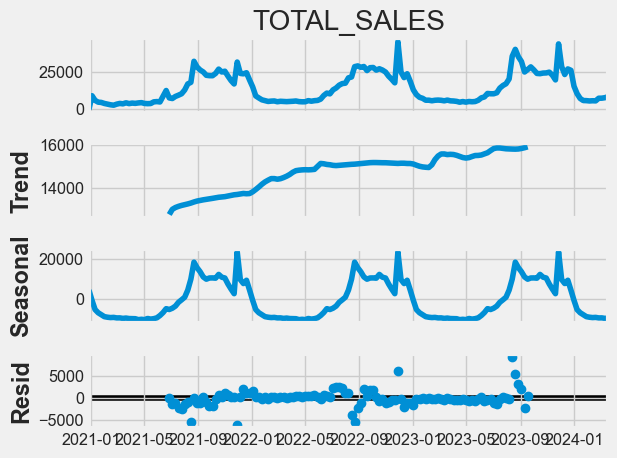

In [583]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomp = seasonal_decompose(sales_ts)

decomp.plot()

plt.show()

In [592]:
from darts.models import RegressionModel 

from darts.metrics import rmse, mae

    #----------------FORECAST WITH LIGHTGBM-----------------------------------------------------------------------------

import matplotlib.pyplot as plt
import optuna
from darts.models import LightGBMModel
from darts.metrics import rmse, mae
from sklearn.linear_model import Ridge


def forecast_lm(target_train,
                      target_test, 
                      covs_train, 
                      covs_test, 
                      add_encoders=add_encoders,
                      lags=[-1, -2, -3, -4,-5,-6,-7,-8,-9,-10],
                        past_lags=[-1, -2, -3, -4,-5,-6,-7,-8,-9,-10],
                        fut_covs = fut_covs,
                        fut_lags=[1,2,3,4,5,6],
                          show_plot=False):
    # Same code as forecast_random_forest, but with LightGBM model
    model = RegressionModel(model=Ridge(),
    lags=lags,
    lags_past_covariates=past_lags,
    lags_future_covariates=fut_lags,
    output_chunk_length=52,
    use_static_covariates=True,
    add_encoders=add_encoders
    )

    model.fit(target_train, past_covariates=covs_train,future_covariates=fut_covs)

    pred = model.predict(n=52,
    series=target_train,
    past_covariates=covs_train)
    #run optuna to minimize RMSE 

    def objective(trial):

        alpha = trial.suggest_float('alpha',.001,10)
        
        # Create and train the model with the hyperparameters
        model = RegressionModel(model=Ridge(alpha=alpha),
        lags=lags,
        lags_past_covariates=past_lags,
        lags_future_covariates=fut_lags,
        output_chunk_length=52,
        use_static_covariates=True,
        add_encoders=add_encoders)


        model.fit(target_train, past_covariates=covs_train,future_covariates=fut_covs)

        # Make predictions with the trained model

        pred = model.predict(n=52, series=target_train, past_covariates=covs_train,future_covariates=fut_covs)

        # Calculate the evaluation metric (Mean Absolute Percentage Error)
        score = rmse(pred, target_test)

        return score
    # Create a study object and optimize the objective function
    study = optuna.create_study(direction='minimize')
    study.optimize(objective, n_trials=100)
    # Get the best parameters
    best_params = study.best_params
    print("Best parameters:", best_params)

    #fit new model with best params 
    model = RegressionModel(model=Ridge(**best_params),
        lags=lags,
        lags_past_covariates=past_lags,
        lags_future_covariates=fut_lags,
        output_chunk_length=52,
        use_static_covariates=True,
        add_encoders=add_encoders,)
        
    model.fit(target_train, past_covariates=covs_train,future_covariates=fut_covs)
    # Make predictions with the trained model
    pred = model.predict(n=len(target_test), series=target_train, past_covariates=covs_train)

 # Calculate RMSE and MAE scores
    rmse_score = round(rmse(pred, target_test) / (target_test.pd_series().max() - target_test.pd_series().min()),3)
    mae_score = round(mae(pred, target_test) / (target_test.pd_series().max() - target_test.pd_series().min()),3)  
    print(f"RMSE: {rmse_score}")
    print(f"MAE: {mae_score}")
    if show_plot == True: 
        plt.style.use('fivethirtyeight')
            # Plot predictions against the test set data
        plt.figure(figsize=(10, 6))
        plt.plot(target_test.pd_series(), label='True')
        plt.plot(pred.pd_series(), label='Predicted')
        plt.title('Ridge Model Predictions vs True Values',fontsize=16)
        plt.xlabel('Time')
        plt.ylabel('Demand')
        plt.legend()
        # Add RMSE and MAE scores as text annotations
        plt.text(plt.xlim()[0], plt.ylim()[1] * 0.3, f'Relative RMSE: {rmse_score * 100}%', ha='left', va='bottom')
        plt.text(plt.xlim()[0], plt.ylim()[1] * 0.25, f'Relative MAE: {mae_score * 100}%', ha='left', va='bottom')
        plt.show()
       


    final_model = RegressionModel(model = Ridge(**best_params),
        lags=lags,
        lags_past_covariates=past_lags,
        lags_future_covariates=fut_lags,
        output_chunk_length=52,
        use_static_covariates=True,
        add_encoders=add_encoders)

    final_model.fit(target,past_covariates=past_covs,future_covariates=fut_covs)

    final_preds = final_model.predict(n=52,
                                       series=target,
                                      future_covariates=fut_covs,
                                       past_covariates=past_covs)

    return final_model, final_preds

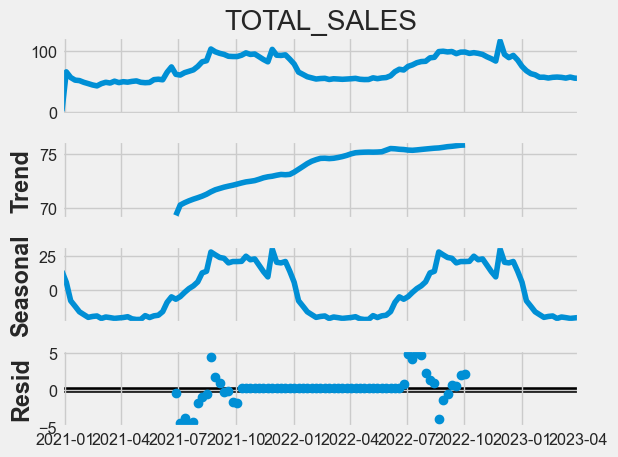

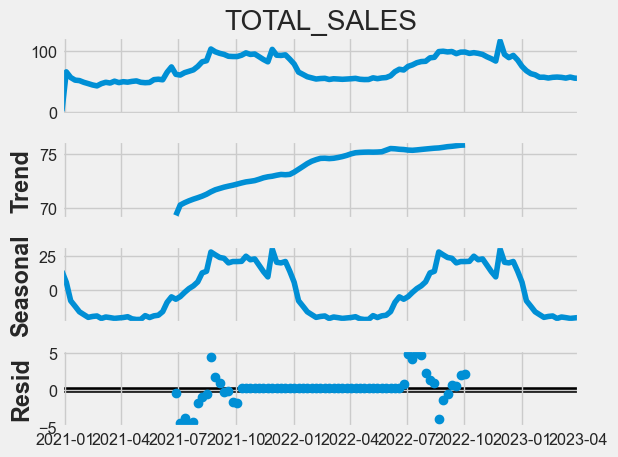

In [606]:
from darts.dataprocessing.transformers import BoxCox

#target_train.plot(label='Target Train Normal') 

bx = BoxCox()

transformed_train,transformed_test = bx.fit_transform([target_train,target_test])

seasonal_decompose(transformed_train.pd_series()).plot()

Best parameters: {'alpha': 0.20843717634702988}
RMSE: 0.11
MAE: 0.09


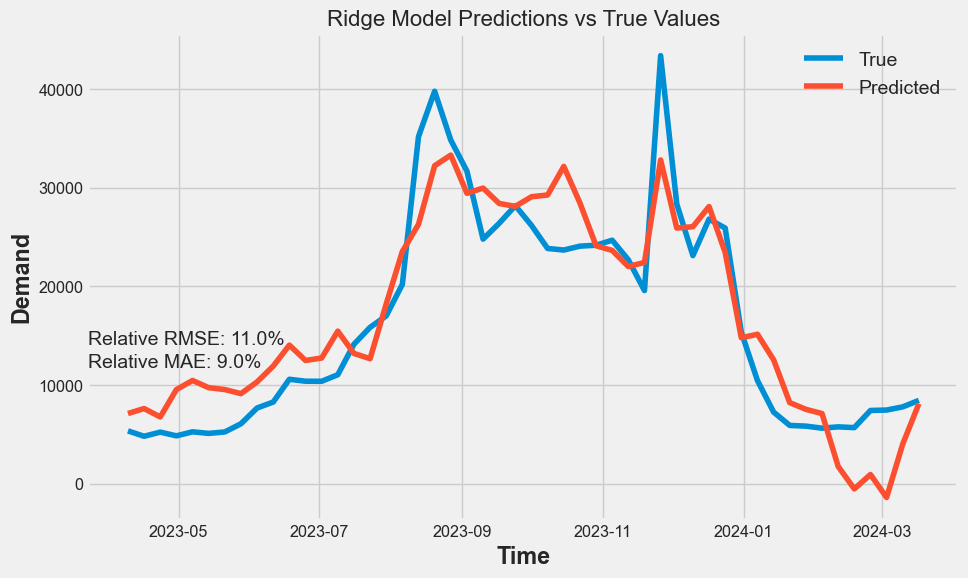

In [620]:
model, pred_series = forecast_lm(target_train,
                  target_test,
                  covs_train,
                  covs_test,
                  add_encoders=add_encoders,
                  fut_covs=fut_covs,
                  show_plot=True,
                  lags=[-1,-2,-3],past_lags = [-1], fut_lags=[-1])

In [632]:
#get regression coefficient dataframe 

reg_coefs = pd.DataFrame(model.model.coef_,columns=model.lagged_feature_names)

#dropping all features that AREN"T important 
cols_to_drop = reg_coefs.columns[reg_coefs.eq(0).all()]

reg_coefs.drop(cols_to_drop,axis=1,inplace=True)

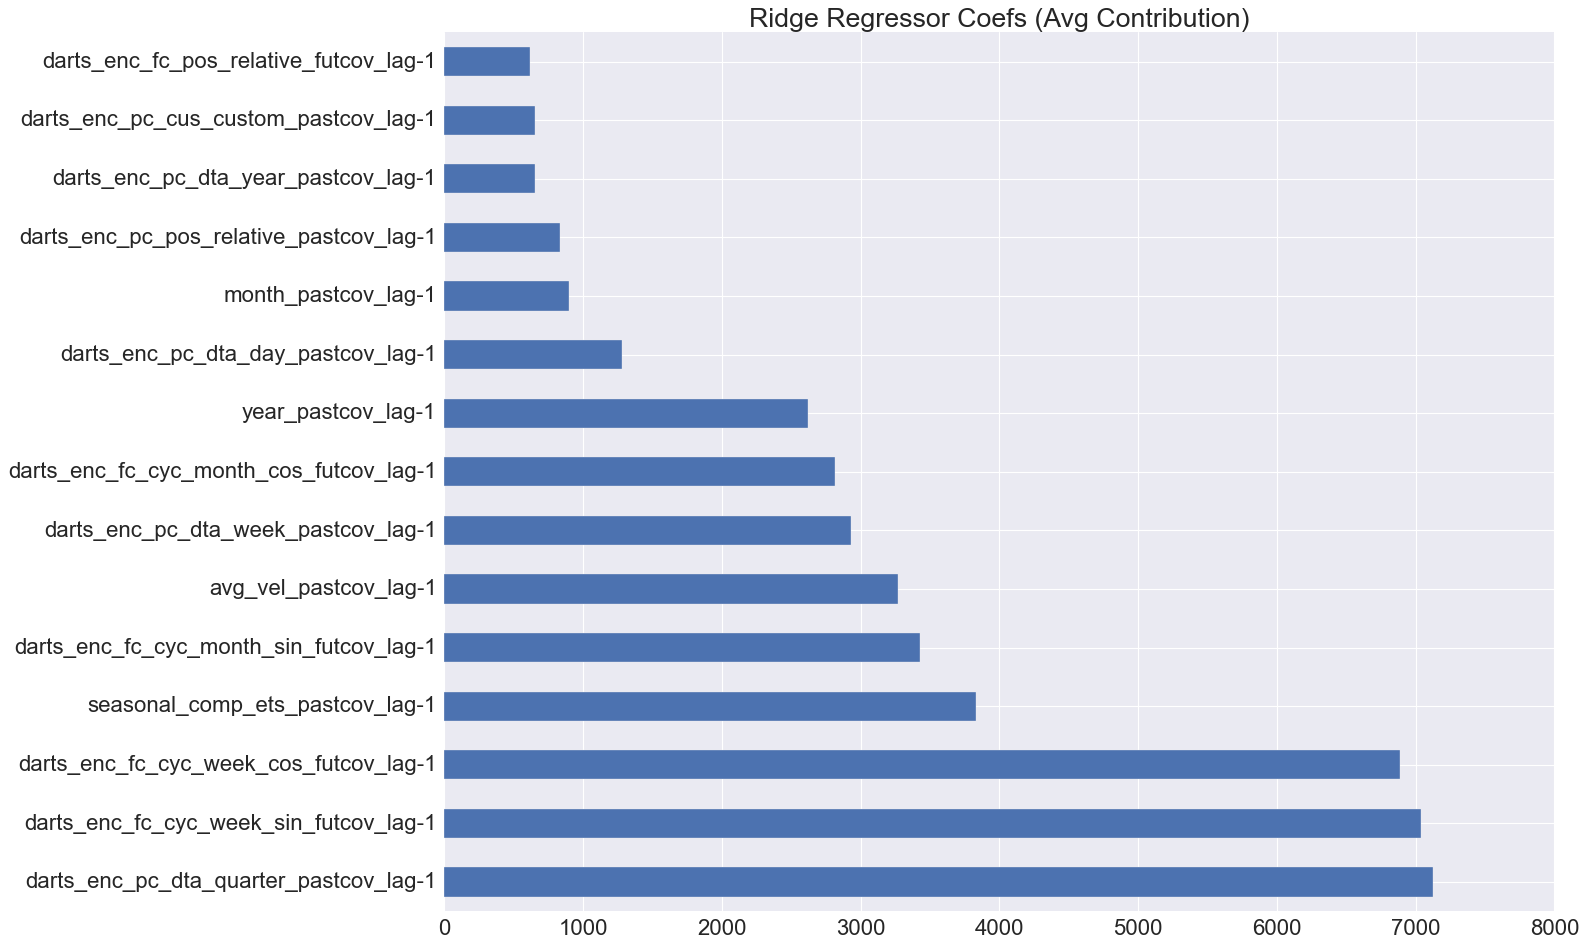

In [667]:
reg_coef_imp = reg_coefs.abs().mean().sort_values(ascending=False)

plt.style.use('seaborn-v0_8')

plt.figure(figsize=(20,12))

reg_coef_imp[:15].plot(figsize=(20,12),
                       kind='barh',
                       fontsize=20)

plt.title('Ridge Regressor Coefs (Avg Contribution)',fontsize=24)

plt.tight_layout()

plt.show()